# Análisis de resultados 

## Librerías empleadas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf

import os  # Para manejar la creación de carpetas

import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)  # Suprimir warnings de overflow
import scipy.stats as stats

import math

from sklearn.model_selection import train_test_split


## Limpieza de datos

### Llamado de archivos

Una ves realizado el proceso de imputacion, se procede a analizar la estacion de interesen, en este proyecto no enficaremos en la estacion Monterrey en estado inactiva correspondiente al codigo 19049. 

En la prarte inicial se devera colocar el nombre del archivo de la estacion imputada (19049_imputados.csv) y el nombre del archivo con los datos orifinales (19049.txt), y ambos se emplear para realizar los sigientes procesos de filtrdo y limpieza de datos.

In [2]:
CSV_Sitio_inputado = '19001_imputado.csv'

TXT_datos_originales = '19001.txt'

### Lectura de archivos

En esta seccion se realiza la identificacion de las colubnas Fecha (la cual corresponde al Index de los datos) y la coluban de datos de precipitacion, tento de los archivos Imputados como de los originales y cambiamos los nombres por PRECIP_imputado y PRECIP_original para poder identificarlos mas adelante, ademas de coloca como Index a la Fecha para facilitar algunos pasos mas adelante

In [3]:
df_csv = pd.read_csv(CSV_Sitio_inputado, parse_dates=['FECHA'])
df_csv.set_index('FECHA', inplace=True)
df_csv.rename(columns={'PRECIP': 'PRECIP_imputado'}, inplace=True)

df_txt = pd.read_csv(TXT_datos_originales, sep=r'\s+', usecols=['FECHA', 'PRECIP'], parse_dates=['FECHA'])
df_txt['PRECIP'] = pd.to_numeric(df_txt['PRECIP'], errors='coerce')  # Manejar 'NULO' como NaN
df_txt.set_index('FECHA', inplace=True)
df_txt.rename(columns={'PRECIP': 'PRECIP_original'}, inplace=True)

Verificamos los cambios realizados si es necesario cambiando la siguiente celda a ejecutable para imprimir la informacion, pasandola de Markdown a Python

print(df_csv.info())
print(df_txt.info())

### union de archivos

Se realiza una union de archivos, tomando como partida el index, considerando que esta organizado por fecha esto se realiza de manera automatica y sencilla

In [4]:
columna_a_unir = df_txt[['PRECIP_original']]
df_csv = df_csv.join(columna_a_unir, how='left')

#print(df_csv.head()) # --> para validar los cambios ejecute

Se eliminan las columnas que no se ocuparan quedandono unicamente con los datos de precipitacion de todas las estaciones consideradas en la imputacion, las estacion imputada y la estacion con los datos originales.

In [5]:
Columnas_a_eliminar=['lat', 'lon', 'station_id']
df_csv.drop(columns = Columnas_a_eliminar, inplace=True)
df = df_csv

#print(df.head())# --> para validar los cambios ejecute

## Filtrado de datos


Condicion 1 : si todos los datos son nulos, tanto en las estaciones de imputacion, la estacion imputada y la estacion original, entonces el valor de la estacion inputada si es diferente de cero sera eliminada.

Condicion 2 : si la columna de datos originales es nula y existen menos de 5 columnas con datos de precipitacion empleados en la imputacion entonces el dato imputado no se considera como valido y se agrega a la mascara de eliminación

Condicion 3 : si la columna de precipitacion original es nula y la columna imputada tiene un valor mayor al de las celdas de imputacion entonces el valor imputado pasa a la mascara de eliminacion.

#------------- Pre filtrado ------------
# 1. Identificar las columnas PRECIP_n (los 'lags')
# Excluimos las columnas principales y la de identificación
cols_precip_n = [
    col for col in df.columns 
    if col.startswith('PRECIP_') and col not in ['PRECIP_imputado', 'PRECIP_original']
]

# 2. Creamos una máscara inicial cuyos cambios se ejecutaran 
mask_eliminar = pd.Series(False, index=df.index)

# 3. Implementación de las Condiciones de Eliminación

        #------------ Condición 1: -------------
todas_nulas_en_pn = df[cols_precip_n].isnull().all(axis=1)
condicion_1 = df['PRECIP_original'].isnull() & todas_nulas_en_pn
mask_eliminar = mask_eliminar | condicion_1

        # ------------ Condición 2 -------------
conteo_no_nulos_en_pn = df[cols_precip_n].notnull().sum(axis=1)
condicion_2 = (df['PRECIP_original'].isnull()) & (conteo_no_nulos_en_pn < 5)
mask_eliminar = mask_eliminar | condicion_2

        # ----------- Condición 3 --------------
max_valor_en_pn = df[cols_precip_n].max(axis=1)
condicion_3 = df['PRECIP_original'].isnull() & (df['PRECIP_imputado'] > max_valor_en_pn)
mask_eliminar = mask_eliminar | condicion_3

# 4. Aplicar el Filtro Final
# El operador '~' invierte la máscara, seleccionando las filas que NO deben ser eliminadas.
df_filtrado = df[~mask_eliminar]

print("Proceso de filtrado completado.")

In [6]:
#------------- Pre filtrado ------------
# 1. Identificar las columnas PRECIP_n (los 'lags')
# Excluimos las columnas principales y la de identificación
cols_precip_n = [
    col for col in df.columns 
    if col.startswith('PRECIP_') and col not in ['PRECIP_imputado', 'PRECIP_original']
]

# Agregar columna 'Año' y 'Semana' si no existen
df['Año'] = df.index.year
df['Semana'] = df.index.isocalendar().week  # Semana del año (1-53)

# Calcular el máximo por año-semana en PRECIP_n (nuevo umbral dinámico para condición 3)
maximos_por_año_semana = df.groupby(['Año', 'Semana'])[cols_precip_n].max().max(axis=1)  # Máximo por año-semana, luego máximo de columnas

# 2. Creamos una máscara inicial cuyos cambios se ejecutaran 
mask_eliminar = pd.Series(False, index=df.index)

# 3. Implementación de las Condiciones de Eliminación

    #------------ Condición 1: -------------
todas_nulas_en_pn = df[cols_precip_n].isnull().all(axis=1)
condicion_1 = df['PRECIP_original'].isnull() & todas_nulas_en_pn
mask_eliminar = mask_eliminar | condicion_1

    # ------------ Condición 2 -------------
conteo_no_nulos_en_pn = df[cols_precip_n].notnull().sum(axis=1)
condicion_2 = (df['PRECIP_original'].isnull()) & (conteo_no_nulos_en_pn < 5)
mask_eliminar = mask_eliminar | condicion_2

    # ----------- Condición 3 Modificada --------------
# Usar máximo semanal específico para el año y semana de cada fila
condicion_3 = df['PRECIP_original'].isnull() & (df['PRECIP_imputado'] > df.apply(lambda row: maximos_por_año_semana.get((row['Año'], row['Semana']), 0), axis=1))
mask_eliminar = mask_eliminar | condicion_3

# 4. Aplicar el Filtro Final
# El operador '~' invierte la máscara, seleccionando las filas que NO deben ser eliminadas.
df_filtrado = df[~mask_eliminar]

print("Proceso de filtrado completado.")
print("Máximos por año-semana usados en condición 3:")
print(maximos_por_año_semana)

Proceso de filtrado completado.
Máximos por año-semana usados en condición 3:
Año   Semana
1941  1          2.3
      36         0.0
      37        82.2
      38        16.5
      39        45.4
                ... 
2025  38        39.4
      39         0.0
      40         0.0
      41        14.8
      42         0.0
Length: 4406, dtype: float64


In [7]:
df_csv = df_filtrado

## Comparcion estadistica


### --->Interpretacion cuatitativa de los Resultados<---

#### Comparación Imputado vs Original:

Conteo: Los 28,470 datos imputados vs 24,443 originales indican que la imputación (e.g., ARIMA o IDW) llenó ~4,027 valores faltantes, mejorando la completitud para análisis de CONAGUA.

Media y Desviación Estándar: Las diferencias mínimas (1.64 vs 1.66 mm; 8.64 vs 8.90 mm) sugieren que la imputación mantuvo la estructura estadística, aunque la variabilidad es alta debido a extremos.

Cuartiles: La similitud en Q1, Q2 y Q3 (0.00-0.01 mm) indica que la imputación no alteró significativamente la distribución en los valores bajos, pero Q3 imputado (0.01 mm) es ligeramente mayor, reflejando ajustes en datos faltantes.

Máximo: El máximo idéntico (533 mm) valida que la imputación preservó eventos extremos, crucial para diseño hidrológico (e.g., curvas IDF).


#### Asimetría (Skewness):

Apartir de este estadistico de mide la asimetría de la distribución. En el cual un valor positivo indica una cola derecha pronunciada, típica de series donde pocos eventos extremos dominan sobre valores bajos.

Un valor de 13.49 es extremadamente alto, lo que sugiere una distribución muy sesgada hacia la derecha. Esto es característico de series de precipitación máxima anual, donde eventos extremos son raros pero influyentes, mientras que la mayoría de los valores son cercanos a los mínimos. Indica una fuerte presencia de lluvias intensas en este grupo.

#### Curtosis (Kurtosis):

Mientras que el método estadistico de Kurtosis mide el grado de eventos pico (picosidad) y el peso de las colas. Un valor mayor a 3 (kurtosis de una distribución normal) indica una distribución leptocúrtica con colas pesadas y un pico agudo.

Un valor de 336.69 es excepcionalmente alto, reflejando un pico muy pronunciado cerca de cero y colas extremadamente pesadas. Esto sugiere una concentración significativa de valores bajos y la presencia de outliers notables, consistente con una serie donde eventos extremos son infrecuentes pero de gran magnitud. La curtosis tan elevada refuerza la idea de una distribución con colas largas, típica de precipitaciones extremas.

### Interpretación en Contexto Hidrológico

La alta asimetría y curtosis indican que la distribución es altamente no normal, lo que invalida el uso de distribuciones paramétricas como la normal sin transformaciones. Esto es común en series hidrológicas y sugiere la necesidad de distribuciones de colas pesadas (e.g., Log Pearson III, Gumbel) para modelar periodos de retorno.

Estos valores destacan la importancia de ajustar modelos que consideren extremos para diseño hidráulico (e.g., drenajes), muestra una distribución altamente asimétrica y leptocúrtica, indicando una fuerte influencia de eventos extremos, lo que requiere un enfoque especializado para su análisis en el contexto de CONAGUA.

In [8]:
# 3. Computar estadísticas descriptivas para cada dataset (independientemente)
stats_imputado = df_filtrado['PRECIP_imputado'].describe()
stats_original = df_txt['PRECIP_original'].describe()

# Agregar skewness y kurtosis
stats_imputado['skewness'] = df_filtrado['PRECIP_imputado'].skew()
stats_imputado['kurtosis'] = df_filtrado['PRECIP_imputado'].kurtosis()
stats_original['skewness'] = df_txt['PRECIP_original'].skew()
stats_original['kurtosis'] = df_txt['PRECIP_original'].kurtosis()

# 4. Crear tabla comparativa de estadísticas
stats_table = pd.DataFrame({
    'Imputado': stats_imputado,
    'Original': stats_original
}).round(2)  # Redondear a 2 decimales
print("Tabla comparativa de valores estadísticos:")
print(stats_table)

Tabla comparativa de valores estadísticos:
          Imputado  Original
count     21005.00   8648.00
mean          3.62      2.71
std          11.14     11.71
min           0.00      0.00
25%           0.00      0.00
50%           0.00      0.00
75%           1.50      0.00
max         320.00    320.00
skewness      8.80     11.10
kurtosis    146.22    198.31


## Graficos comparativos originales vs imputados

C:\Users\USER\AppData\Local\Temp\ipykernel_3576\1015077030.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado['Mes'] = df_filtrado.index.month


Imputados_VS_Originales' en C:\Users\USER\Desktop\Angel


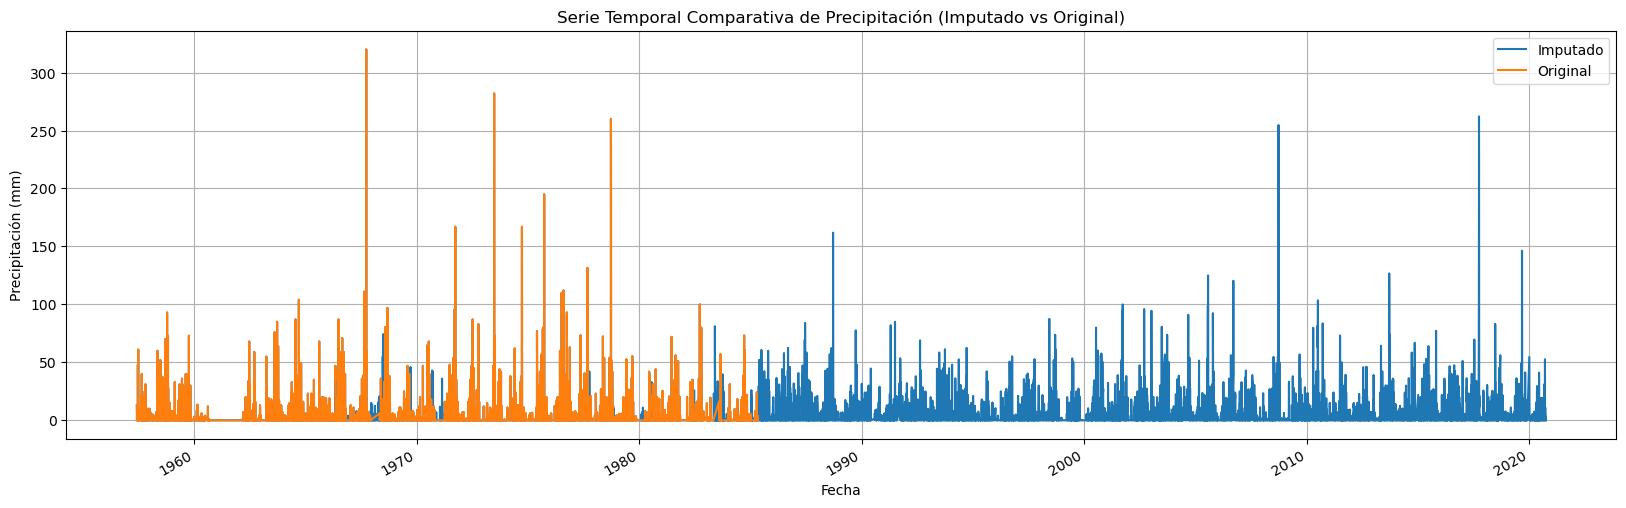

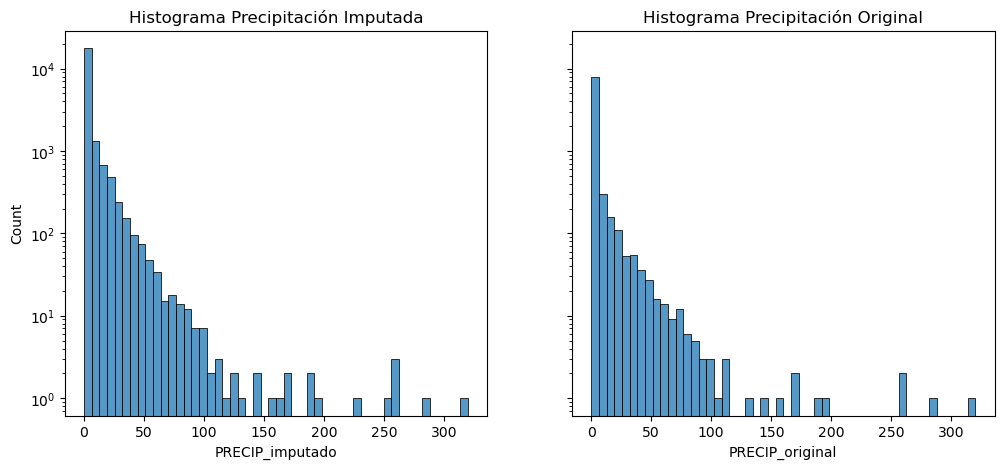

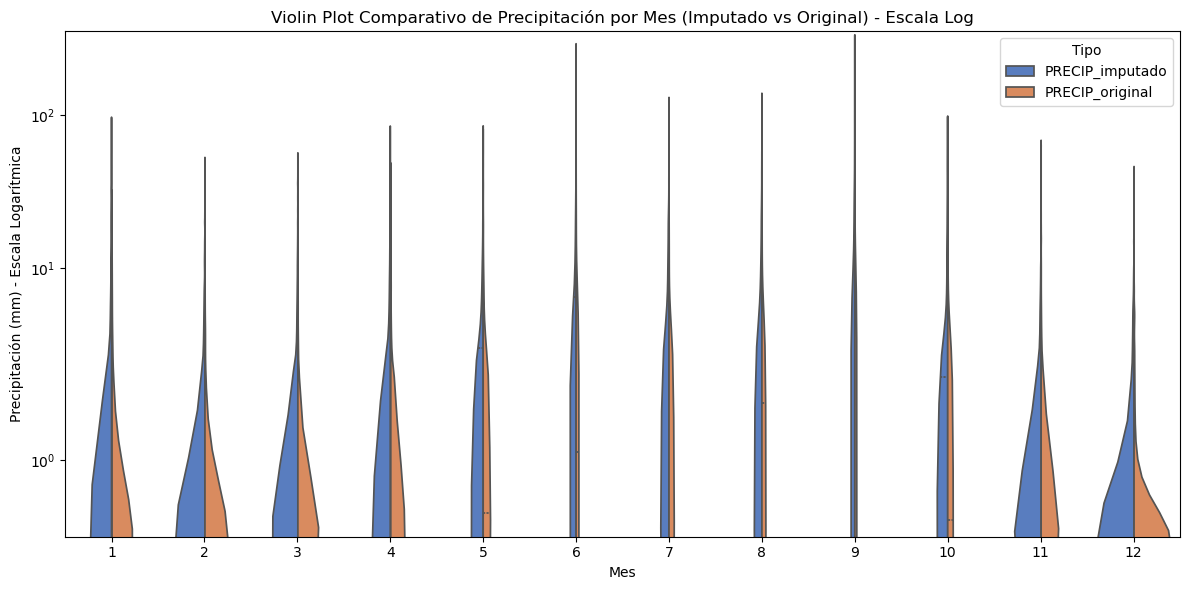

In [9]:



# 5. Análisis temporal: agregar columna de Mes para cada dataset
df_filtrado['Mes'] = df_filtrado.index.month
df_txt['Mes'] = df_txt.index.month

# 6. Gráficos combinados y comparativos
# Serie temporal superpuesta
plt.figure(figsize=(20, 6))
df_filtrado['PRECIP_imputado'].plot(label='Imputado')
df_txt['PRECIP_original'].plot(label='Original')
plt.title('Serie Temporal Comparativa de Precipitación (Imputado vs Original)')
plt.xlabel('Fecha')
plt.ylabel('Precipitación (mm)')
plt.grid(True)
plt.legend()

try:
    plt.savefig('imagen/Imputados_VS_Originales', dpi=600, bbox_inches='tight')
    print(f"Imputados_VS_Originales' en {os.getcwd()}")
except Exception as e:
    print(f"Error al guardar el gráfico: {e}")
plt.show()


# Histogramas side-by-side para distribución
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
sns.histplot(df_filtrado['PRECIP_imputado'].dropna(), bins=50, ax=axes[0])#kde=True
axes[0].set_title('Histograma Precipitación Imputada')
axes[0].set_yscale('log')  # Escala semilogarítmica en y
sns.histplot(df_txt['PRECIP_original'].dropna(), bins=50,  ax=axes[1])#kde=True,
axes[1].set_title('Histograma Precipitación Original')
axes[1].set_yscale('log')  # Escala semilogarítmica en y
plt.show()




# Boxplot mensual comparativo con eje Y en escala logarítmica y rango completo
df_filtrado_melt = df_filtrado.reset_index().melt(id_vars=['Mes'], value_vars=['PRECIP_imputado'], 
                                        var_name='Tipo', value_name='PRECIP')
df_txt_melt = df_txt.reset_index().melt(id_vars=['Mes'], value_vars=['PRECIP_original'], 
                                        var_name='Tipo', value_name='PRECIP')
df_melt_combined = pd.concat([df_filtrado_melt, df_txt_melt], ignore_index=True)

# Calcular límites del eje Y basados en el rango completo de datos
min_precip = df_melt_combined['PRECIP'].min()
max_precip = df_melt_combined['PRECIP'].max()
y_min = min_precip if min_precip > 0 else 0.1  # Mínimo real o 0.1 si hay ceros
y_max = max_precip * 1.1  # Aumentar ligeramente para mostrar outliers

plt.figure(figsize=(12, 6))
sns.violinplot(x='Mes', y='PRECIP', hue='Tipo', data=df_melt_combined, palette='muted', split=True, inner='quartile')
plt.yscale('symlog')  # Escala simétrica logarítmica para manejar cero
plt.ylim(y_min, y_max)  # Establecer rango completo del eje Y
plt.title('Violin Plot Comparativo de Precipitación por Mes (Imputado vs Original) - Escala Log')
plt.xlabel('Mes')
plt.ylabel('Precipitación (mm) - Escala Logarítmica')
plt.legend(title='Tipo')
plt.tight_layout()
plt.show()




Porcentaje_Originales_vs_Imputados' en C:\Users\USER\Desktop\Angel


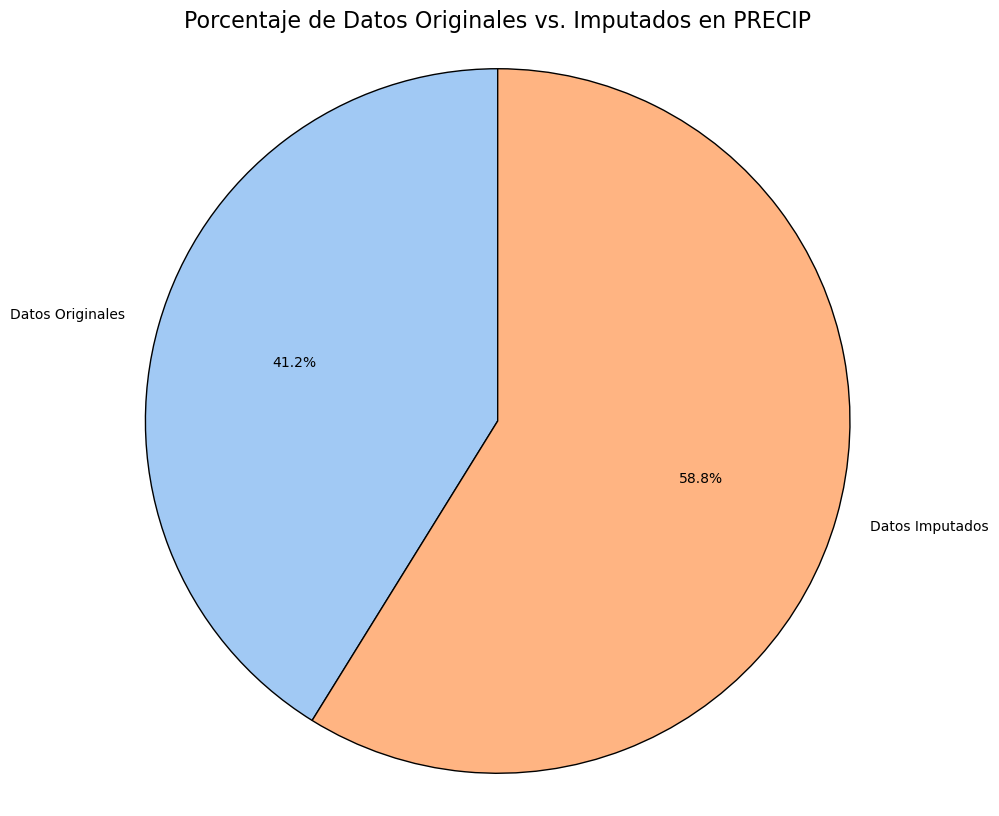

In [10]:
# 3. Lógica de Conteo de Datos Originales vs. Imputados
# Se cuenta cuántos valores en 'PRECIP_original' NO son nulos.
original_count = df_filtrado['PRECIP_original'].notnull().sum()

# Se cuenta cuántos valores en 'PRECIP_original' SÍ son nulos (estos fueron los imputados).
imputed_count = df_filtrado['PRECIP_original'].isnull().sum()

counts = [original_count, imputed_count]

labels = ['Datos Originales', 'Datos Imputados']

colors = sns.color_palette('pastel')[0:2]


plt.figure(figsize=(10, 10))
plt.pie(counts, 
        labels=labels, 
        colors=colors, 
        autopct='%1.1f%%', 
        startangle=90,   
        wedgeprops={'edgecolor': 'black', 'linewidth': 1})
plt.title('Porcentaje de Datos Originales vs. Imputados en PRECIP', fontsize=16)
plt.axis('equal')
try:
    plt.savefig('imagen/Porcentaje_Originales_vs_Imputados.png', dpi=600, bbox_inches='tight')
    print(f"Porcentaje_Originales_vs_Imputados' en {os.getcwd()}")
except Exception as e:
    print(f"Error al guardar el gráfico: {e}")
plt.show()

### Análisis de Lluvias

Se busca aplicar los siguientes análisis al conjunto de datos de precipitación:  

* (Como mínimo 3 pruebas, de las cuales al menos 2 deben cumplir con el criterio de homogeneidad) 2- Utilizar métodos de Cramer, Helmert y T Student

* Análisis de independencia por el método de Anderson

* Estimación del periodo de retorno empirico por elmetodo de Weibull y probabilidad de ocurrencia- para los valores máximos anuales de lluvia acumulada en 24 horas

* lluvia acumulada en 24 horas, empleando funciones de distribución de probabilidad de análisis hidrológicos (Presentar como mínimo las establecidas en la sugerencia :  Utilizar funciones de distribución de probabilidad Normal, Log normal, Log Pearson, Exponencial, Gamma, Pearson, Pearson III, General de valores extremos, Gumbel, Gumbel para 2 poblaciones

* Seleccionar la función de distribución de probabilidad de acuerdo con los criterios de bondad de ajuste y seleccionar los periodos de retorno a partir del análisis. 4

In [11]:
# DATOS IMPUTADOS Paso 1: Extraer máximos anuales de PRECIP_imputado (asumiendo diaria ~24h acumulada)

max_annual = df_filtrado['PRECIP_imputado'].resample('YE').max().dropna()

print("Máximos anuales extraídos:")
print(max_annual.head(200))


Máximos anuales extraídos:
FECHA
1957-12-31     61.0
1958-12-31     93.0
1959-12-31     73.0
1960-12-31     13.5
1962-12-31     68.0
              ...  
2016-12-31     47.5
2017-12-31    262.2
2018-12-31     83.2
2019-12-31    146.3
2020-12-31     54.7
Name: PRECIP_imputado, Length: 63, dtype: float64


In [12]:
# DATOS IMPUTADOS Paso 2: Pruebas de Homogeneidad (dividir en dos grupos: primera/segunda mitad)
# Alternativa Estratificada (mejor para ceros)
# Crea etiquetas para estratificar: 0 para ceros, 1 para >0
labels = np.where(max_annual > 0, 1, 0)
group1_values, group2_values = train_test_split(max_annual.values, test_size=0.5, stratify=labels, random_state=42)
group1 = group1_values
group2 = group2_values

# 2.1 Cramér-von Mises
cvm = stats.cramervonmises_2samp(group1, group2)
print(f"Cramér-von Mises: stat={cvm.statistic:.4f}, p={cvm.pvalue:.4f}")

# 2.2 t-Student (para medias)
t_stat, t_p = stats.ttest_ind(group1, group2)
print(f"t-Student: stat={t_stat:.4f}, p={t_p:.4f}")

# 2.3 Levene (proxy para Helmert, homogeneidad de varianzas)
lev_stat, lev_p = stats.levene(group1, group2)
print(f"Levene (Helmert proxy): stat={lev_stat:.4f}, p={lev_p:.4f}")

# Conclusión homogeneidad
if sum([cvm.pvalue > 0.05, t_p > 0.05, lev_p > 0.05]) >= 2:
    print("Homogénea (al menos 2 pruebas cumplen).")
else:
    print("No homogénea.")

Cramér-von Mises: stat=0.1552, p=0.3822
t-Student: stat=0.1535, p=0.8785
Levene (Helmert proxy): stat=0.0373, p=0.8475
Homogénea (al menos 2 pruebas cumplen).


In [13]:

# -------------------------------------------------
# 1. División TEMPORAL (oficial)
mid = len(max_annual) // 2
g1_temp = max_annual.values[:mid]
g2_temp = max_annual.values[mid:]

# 2. División ESTRATIFICADA (diagnóstico)
labels = (max_annual > 0).astype(int)
g1_strat, g2_strat = train_test_split(
    max_annual.values, test_size=0.5, stratify=labels, random_state=42
)

# -------------------------------------------------
def test_homogeneity(g1, g2, name):
    cvm = stats.cramervonmises_2samp(g1, g2)
    t   = stats.ttest_ind(g1, g2)
    lev = stats.levene(g1, g2)
    print(f"\n--- {name} ---")
    print(f"CvM: stat={cvm.statistic:.4f}, p={cvm.pvalue:.4f}")
    print(f"t-Student: stat={t.statistic:.4f}, p={t.pvalue:.4f}")
    print(f"Levene: stat={lev.statistic:.4f}, p={lev.pvalue:.4f}")
    return [cvm.pvalue, t.pvalue, lev.pvalue]

p_temp = test_homogeneity(g1_temp, g2_temp, "Temporal")
p_strat = test_homogeneity(g1_strat, g2_strat, "Estratificada")


--- Temporal ---
CvM: stat=0.1834, p=0.3078
t-Student: stat=1.2913, p=0.2015
Levene: stat=1.1936, p=0.2789

--- Estratificada ---
CvM: stat=0.1552, p=0.3822
t-Student: stat=0.1535, p=0.8785
Levene: stat=0.0373, p=0.8475


Serie de Valores Máximos Anuales de Precipitación' en C:\Users\USER\Desktop\Angel


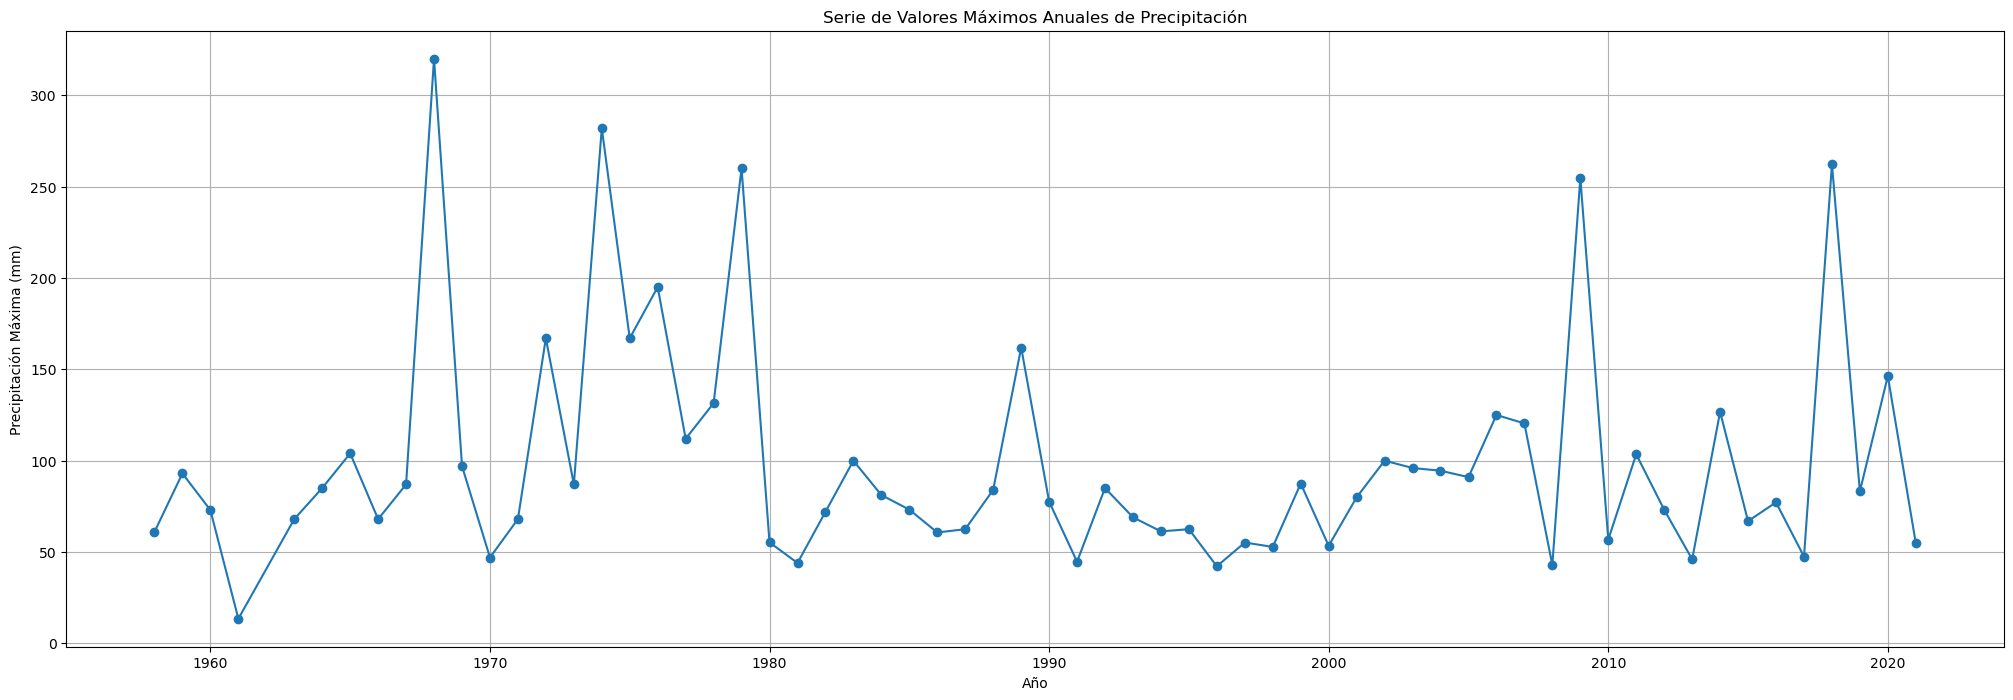

In [14]:
# Visualizar la serie para inspección inicial
max_annual = df_filtrado['PRECIP_imputado'].resample('YE').max().dropna()

plt.figure(figsize=(25, 8))
plt.plot(max_annual.index, max_annual.values, marker='o')
plt.title('Serie de Valores Máximos Anuales de Precipitación')
plt.xlabel('Año')
plt.ylabel('Precipitación Máxima (mm)')
plt.grid(True)

try:
    plt.savefig('imagen/Serie de Valores Máximos Anuales de Precipitación.png', dpi=600, bbox_inches='tight')
    print(f"Serie de Valores Máximos Anuales de Precipitación' en {os.getcwd()}")
except Exception as e:
    print(f"Error al guardar el gráfico: {e}")

plt.show()

Serie de Valores Máximos Mensuales de Precipitación' en C:\Users\USER\Desktop\Angel


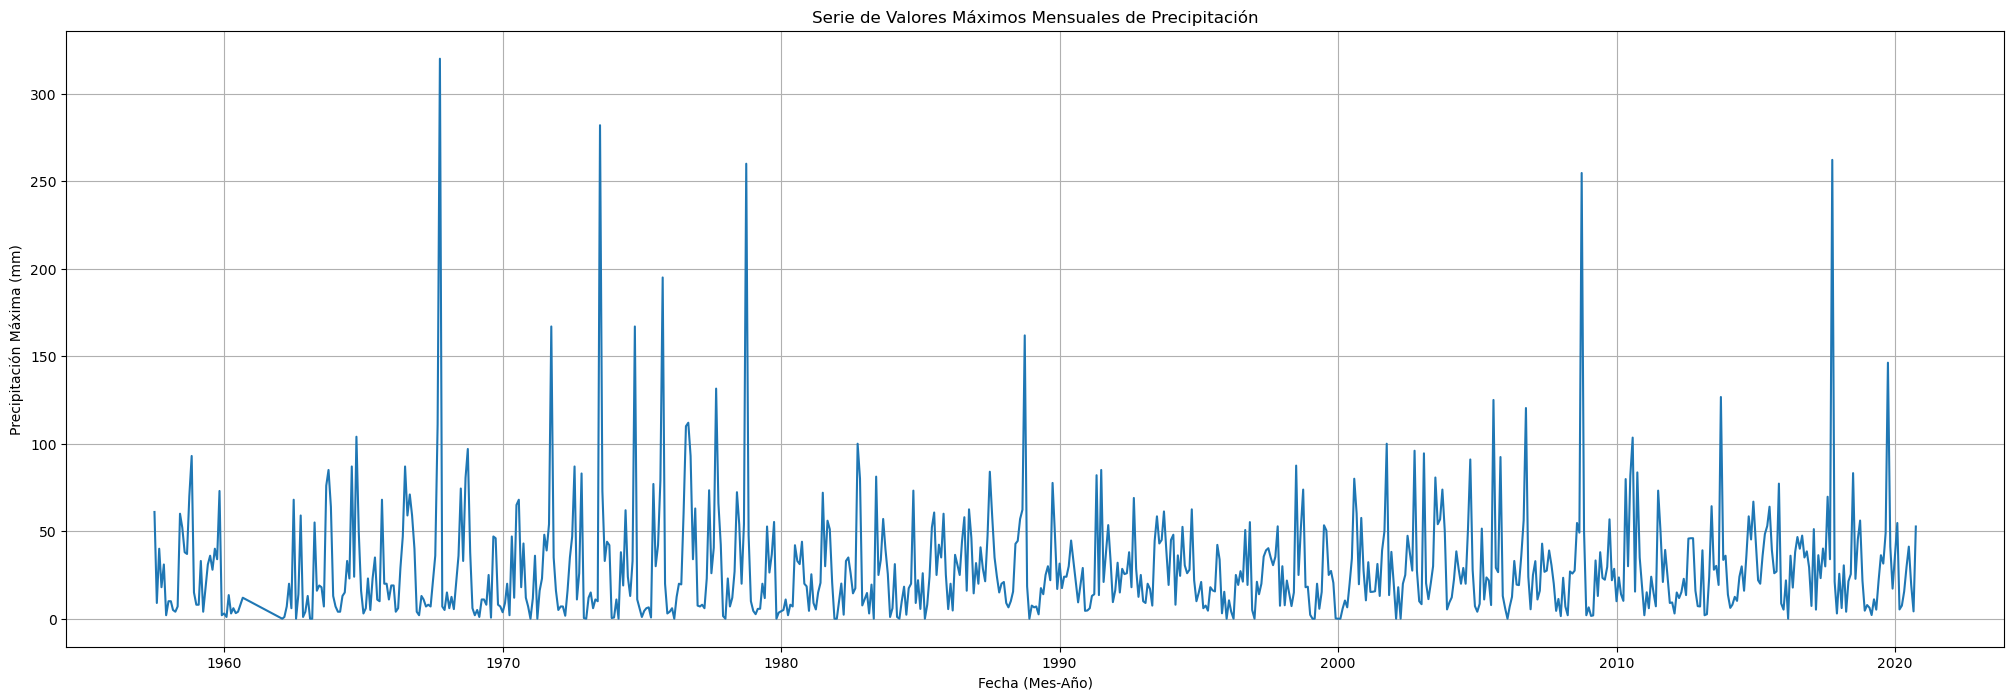

In [15]:
# Visualizar la serie para inspección inicial
max_monthly = df_filtrado['PRECIP_imputado'].resample('ME').max().dropna()

plt.figure(figsize=(25, 8))
plt.plot(max_monthly.index, max_monthly.values)#, marker='o'
plt.title('Serie de Valores Máximos Mensuales de Precipitación')
plt.xlabel('Fecha (Mes-Año)')
plt.ylabel('Precipitación Máxima (mm)')
plt.grid(True)

try:
    plt.savefig('imagen/Serie de Valores Máximos Mensuales de Precipitación.png', dpi=600, bbox_inches='tight')
    print(f"Serie de Valores Máximos Mensuales de Precipitación' en {os.getcwd()}")
except Exception as e:
    print(f"Error al guardar el gráfico: {e}")

plt.show()

Anderson-Darling: stat=4.8813, críticos=[0.545 0.621 0.744 0.868 1.033]
ACF (lags 1-5): [0.02896285 0.12985149 0.04713114 0.15282499 0.07124996]
Funcion_de_autocorrelacion_ACF_Datos_Imputados' en C:\Users\USER\Desktop\Angel


<Figure size 1000x500 with 0 Axes>

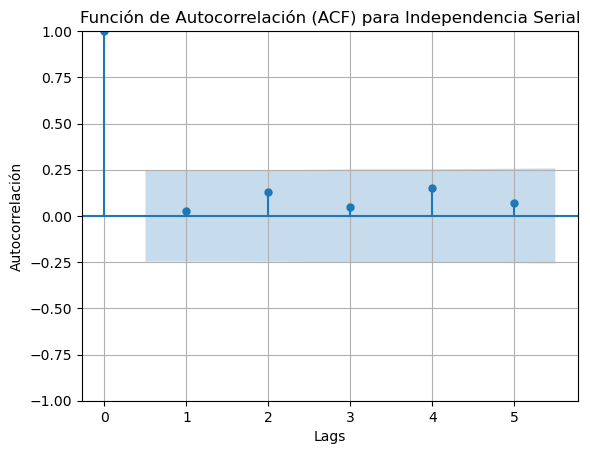

In [16]:
# DATOS IMPUTADOS Paso 3: Análisis de Independencia por Anderson-Darling + ACF
# 3.1 Anderson-Darling para normalidad
ad = stats.anderson(max_annual, dist='norm')
print(f"Anderson-Darling: stat={ad.statistic:.4f}, críticos={ad.critical_values}")

# 3.2 ACF para independencia serial (lags 1-5)
acf_vals = acf(max_annual, nlags=5)[1:]  # Ignora lag 0
print(f"ACF (lags 1-5): {acf_vals}")

# Visualizar ACF (corregido)
plt.figure(figsize=(10, 5))
plot_acf(max_annual, lags=5)
plt.title('Función de Autocorrelación (ACF) para Independencia Serial')
plt.xlabel('Lags')
plt.ylabel('Autocorrelación')
plt.grid(True)

try:
    plt.savefig('imagen/Funcion_de_autocorrelacion_ACF_Datos_Imputados', dpi=600, bbox_inches='tight')
    print(f"Funcion_de_autocorrelacion_ACF_Datos_Imputados' en {os.getcwd()}")
except Exception as e:
    print(f"Error al guardar el gráfico: {e}")
plt.show()

# Conclusión: Si ACF ~0, independiente; valores altos indican dependencia.

### Analisis de Weibull para la estacion CON IMPUTACIÓN

Periodos de Retorno por Weibull (primeros 5):
    Max_Anual  T_r_Weibull  Prob_Occ
0      320.00    64.000000  0.015625
1      282.00    32.000000  0.031250
2      262.20    21.333333  0.046875
3      260.00    16.000000  0.062500
4      254.70    12.800000  0.078125
5      195.00    10.666667  0.093750
6      167.00     9.142857  0.109375
7      167.00     8.000000  0.125000
8      161.90     7.111111  0.140625
9      146.30     6.400000  0.156250
10     131.50     5.818182  0.171875
11     126.70     5.333333  0.187500
12     125.01     4.923077  0.203125
13     120.40     4.571429  0.218750
14     112.00     4.266667  0.234375
15     104.00     4.000000  0.250000
16     103.50     3.764706  0.265625
17     100.00     3.555556  0.281250
18     100.00     3.368421  0.296875
19      97.00     3.200000  0.312500
Periodo_de_Retorno_Weibull_Datos_Datos_Imputados' en C:\Users\USER\Desktop\Angel


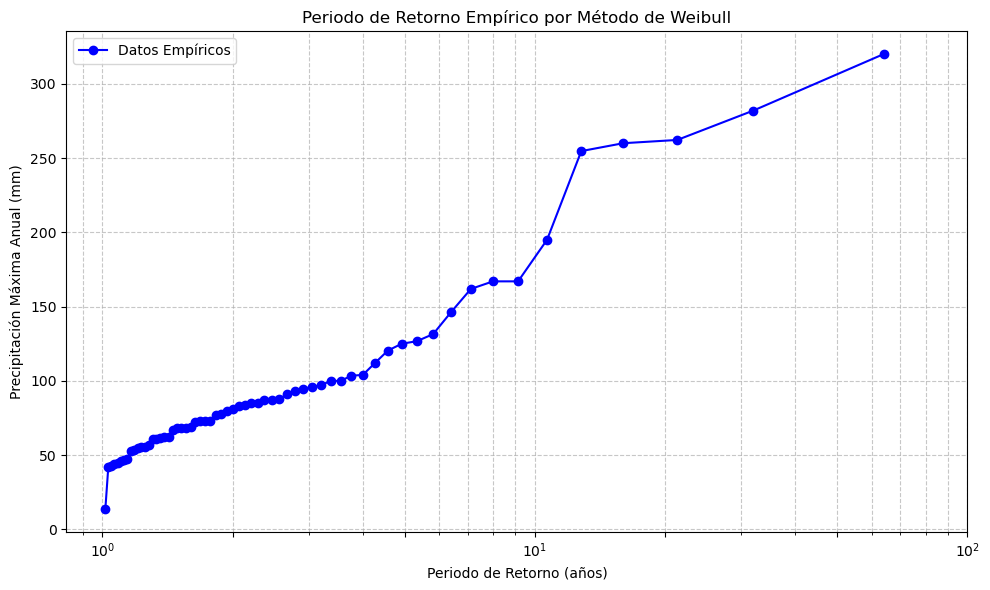

In [17]:
# DATOS IMPUTADOS Paso 4: Periodo de Retorno Empírico por Weibull
n = len(max_annual)
sorted_max = np.sort(max_annual)[::-1]  # Descendente
ranks = np.arange(1, n + 1)
t_r_weibull = (n + 1) / ranks
prob_occ = 1 / t_r_weibull

# DataFrame de resultados
df_weibull = pd.DataFrame({
    'Max_Anual': sorted_max,
    'T_r_Weibull': t_r_weibull,
    'Prob_Occ': prob_occ
})
print("Periodos de Retorno por Weibull (primeros 5):")
print(df_weibull.head(20))

# Gráfico de Periodo de Retorno (1 a 1000 años)
plt.figure(figsize=(10, 6))
plt.plot(t_r_weibull, sorted_max, 'b-o', label='Datos Empíricos')
plt.xscale('log')  # Escala logarítmica para abarcar 1 a 1000
#plt.yscale('log')
plt.xticks([1, 2, 5, 10, 20, 50, 100])  # Puntos clave
plt.xlabel('Periodo de Retorno (años)')
plt.ylabel('Precipitación Máxima Anual (mm)')
plt.title('Periodo de Retorno Empírico por Método de Weibull')
plt.grid(True, which='both', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()

try:
    plt.savefig('imagen/Periodo_de_Retorno_Weibull_Datos_Imputados', dpi=600, bbox_inches='tight')
    print(f"Periodo_de_Retorno_Weibull_Datos_Datos_Imputados' en {os.getcwd()}")
except Exception as e:
    print(f"Error al guardar el gráfico: {e}")
plt.show()


si arriba es no homogenea weibull no aplica ya que se consideraria unicamente para cuencas estables en su periodo

Distribución: Normal, Parámetros: (98.74115713260456, 62.2517401485455), KS p-valor: 0.0023
Distribución: Log Normal, Parámetros: (0.5186583813012272, -3.072605528370532, 88.22015143924979), KS p-valor: 0.3351
Distribución: Exponencial, Parámetros: (13.5, 85.24115713260456), KS p-valor: 0.0002
Distribución: Gamma, Parámetros: (0.33126213571908825, 13.499999999999998, 6.627038550494358), KS p-valor: 0.0000
Distribución: Pearson III, Parámetros: (1.2014609394987446, 98.74118759141447, 54.415726415387866), KS p-valor: 0.1247
Distribución: Log Pearson, Parámetros: (1.2073563486785641, 4.463617129126974, 0.5044145962578055), KS p-valor: 0.9437
Distribución: General Valores Extremos, Parámetros: (-0.19618498690473435, 70.45572578275804, 33.82750265780963), KS p-valor: 0.5960
Distribución: Gumbel, Parámetros: (74.15298769061734, 37.19595014394746), KS p-valor: 0.2719
Distribución: Gumbel 2 Poblaciones, Parámetros: (74.15298769061734, 37.19595014394746), KS p-valor: 0.3653
Comparación de Distr

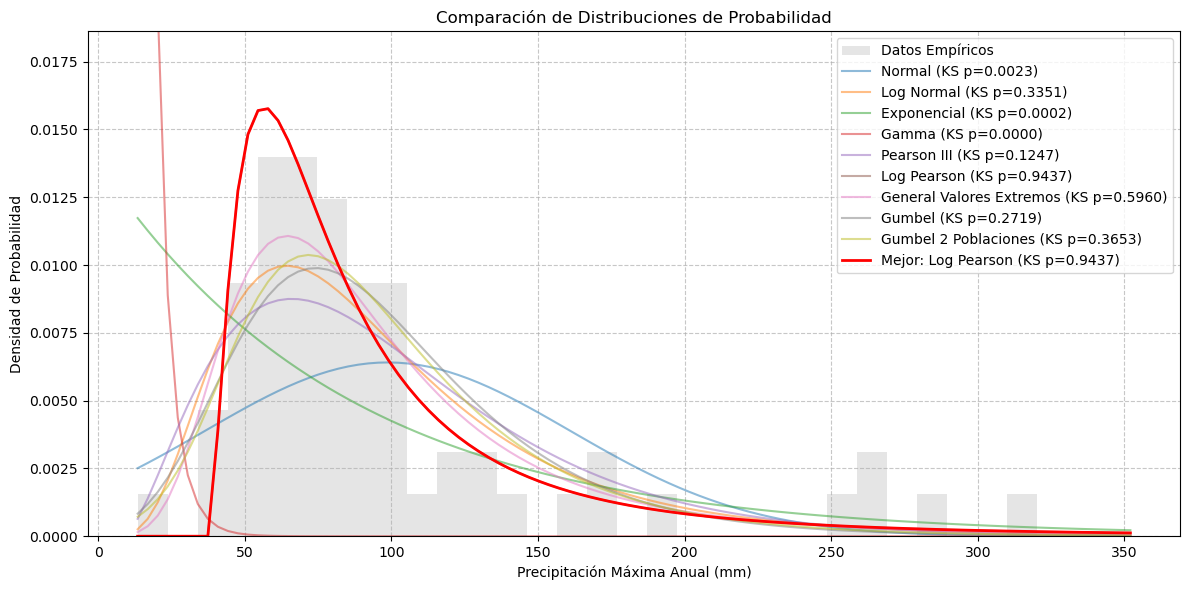

Resultados de Ajustes:
Normal: KS stat=0.2282, p=0.0023
Log Normal: KS stat=0.1163, p=0.3351
Exponencial: KS stat=0.2700, p=0.0002
Gamma: KS stat=0.9825, p=0.0000
Pearson III: KS stat=0.1457, p=0.1247
Log Pearson: KS stat=0.0640, p=0.9437
General Valores Extremos: KS stat=0.0943, p=0.5960
Gumbel: KS stat=0.1232, p=0.2719
Gumbel 2 Poblaciones: KS stat=0.1134, p=0.3653


In [18]:

distributions = {
    'Normal': stats.norm,
    'Log Normal': stats.lognorm,
    'Exponencial': stats.expon,
    'Gamma': stats.gamma,
    'Pearson III': stats.pearson3,
    'Log Pearson': lambda d: stats.pearson3.fit(np.log(d + 1e-10)),
    'General Valores Extremos': stats.genextreme,
    'Gumbel': stats.gumbel_r,
    'Gumbel 2 Poblaciones': lambda d: (stats.gumbel_r.fit(d[:len(d)//2]), stats.gumbel_r.fit(d[len(d)//2:])),
}

results = {}
# Ajustar x_range para evitar valores cercanos a cero
x_min = max(0.1, min(max_annual))  # Mínimo positivo
x_max = min(max(max_annual) * 1.1, 400)
x_range = np.linspace(x_min, x_max, 100)

all_y_values = []

plt.figure(figsize=(12, 6))
# Añadir histograma como fondo
plt.hist(max_annual, bins=30, alpha=0.2, density=True, color='gray', label='Datos Empíricos')

for name, dist in distributions.items():
    if name == 'Log Pearson':
        params = dist(max_annual)
        pdf = lambda x: np.where(x > 0, stats.pearson3.pdf(np.log(np.clip(x, 1e-5, None)), *params) / np.clip(x, 1e-5, None), 0)
        cdf = lambda x: np.where(x > 0, stats.pearson3.cdf(np.log(np.clip(x, 1e-5, None)), *params), 0)
    elif name == 'Gumbel 2 Poblaciones':
        params1, params2 = dist(max_annual)
        pdf = lambda x: 0.5 * stats.gumbel_r.pdf(x, *params1) + 0.5 * stats.gumbel_r.pdf(x, *params2)
        cdf = lambda x: 0.5 * stats.gumbel_r.cdf(x, *params1) + 0.5 * stats.gumbel_r.cdf(x, *params2)
    else:
        params = dist.fit(max_annual)
        pdf = lambda x: dist.pdf(x, *params)
        cdf = lambda x: dist.cdf(x, *params)
    
    # Prueba KS con la CDF definida
    ks_stat, ks_p = stats.kstest(max_annual, cdf)
    results[name] = {'KS_stat': ks_stat, 'KS_p': ks_p, 'params': params}
    
    # Depuración: Verificar parámetros
    print(f"Distribución: {name}, Parámetros: {params}, KS p-valor: {ks_p:.4f}")
    
    # Graficar cada distribución, manejando valores inválidos
    y_vals = [pdf(x) if not (np.isnan(pdf(x)) or np.isinf(pdf(x))) else 0 for x in x_range]
    all_y_values.extend(y_vals) # Recolecta todos los valores de y

    plt.plot(x_range, y_vals, label=f'{name} (KS p={ks_p:.4f})', alpha=0.5)

# Destacar la mejor distribución (mayor KS_p)
best = max(results, key=lambda k: results[k]['KS_p'])
best_params = results[best]['params']
if best == 'Log Pearson':
    best_pdf = lambda x: np.where(x > 0, stats.pearson3.pdf(np.log(np.clip(x, 1e-5, None)), *best_params) / np.clip(x, 1e-5, None), 0)
elif best == 'Gumbel 2 Poblaciones':
    best_params1, best_params2 = best_params
    # Validar que los parámetros sean tuplas
    if not (isinstance(best_params1, tuple) and isinstance(best_params2, tuple)):
        print(f"Error en 'Gumbel 2 Poblaciones': Parámetros no válidos, usando Gumbel simple como fallback.")
        best_params = stats.gumbel_r.fit(max_annual)
        best_pdf = lambda x: stats.gumbel_r.pdf(x, *best_params)
    else:
        best_pdf = lambda x: 0.5 * stats.gumbel_r.pdf(x, *best_params1) + 0.5 * stats.gumbel_r.pdf(x, *best_params2)
else:
    best_pdf = lambda x: distributions[best].pdf(x, *best_params)
y_best = [best_pdf(x) if not (np.isnan(best_pdf(x)) or np.isinf(best_pdf(x))) else 0 for x in x_range]
plt.plot(x_range, y_best, 'r-', linewidth=2, label=f'Mejor: {best} (KS p={results[best]["KS_p"]:.4f})')

all_y_values = np.array(all_y_values)

finite_y_values = all_y_values[np.isfinite(all_y_values)]

if len(finite_y_values) > 0:
    y_limit = np.percentile(finite_y_values, 99.5) * 1.2 # Damos un 20% de margen
    plt.ylim(0, y_limit)

plt.title('Comparación de Distribuciones de Probabilidad')
plt.xlabel('Precipitación Máxima Anual (mm)')
plt.ylabel('Densidad de Probabilidad')
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

try:
    plt.savefig('imagen/Comparación de Distribuciones de Probabilidad', dpi=600, bbox_inches='tight')
    print(f"Comparación de Distribuciones de Probabilidad' en {os.getcwd()}")
except Exception as e:
    print(f"Error al guardar el gráfico: {e}")



plt.show()

print("Resultados de Ajustes:")
for name, res in results.items():
    print(f"{name}: KS stat={res['KS_stat']:.4f}, p={res['KS_p']:.4f}")

Distribución: Normal, Parámetros: (98.74115713260456, 62.2517401485455), KS p-valor: 0.0023
Distribución: Log Normal, Parámetros: (0.5186583813012272, -3.072605528370532, 88.22015143924979), KS p-valor: 0.3351
Distribución: Exponencial, Parámetros: (13.5, 85.24115713260456), KS p-valor: 0.0002
Distribución: Gamma, Parámetros: (0.33126213571908825, 13.499999999999998, 6.627038550494358), KS p-valor: 0.0000
Distribución: Pearson III, Parámetros: (1.2014609394987446, 98.74118759141447, 54.415726415387866), KS p-valor: 0.1247
Distribución: Log Pearson, Parámetros: (1.2073563486785641, 4.463617129126974, 0.5044145962578055), KS p-valor: 0.9437
Distribución: General Valores Extremos, Parámetros: (-0.19618498690473435, 70.45572578275804, 33.82750265780963), KS p-valor: 0.5960
Distribución: Gumbel, Parámetros: (74.15298769061734, 37.19595014394746), KS p-valor: 0.2719
Distribución: Gumbel 2 Poblaciones, Parámetros: (74.15298769061734, 37.19595014394746), KS p-valor: 0.3653
Comparación de Distr

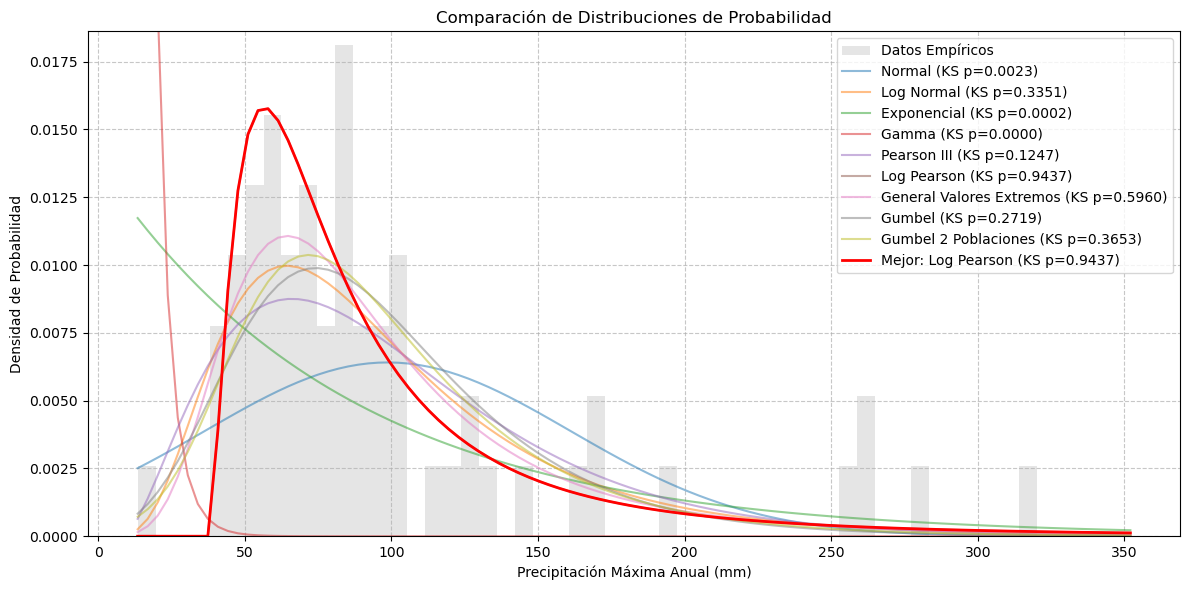

Resultados de Ajustes:
Normal: KS stat=0.2282, p=0.0023, MSE=13506.9052, SE=7.8137, Chi2_stat=105.2329
Log Normal: KS stat=0.1163, p=0.3351, MSE=13499.5823, SE=7.8126, Chi2_stat=30.1875
Exponencial: KS stat=0.2700, p=0.0002, MSE=13492.5919, SE=7.8205, Chi2_stat=39.7235
Gamma: KS stat=0.9825, p=0.0000, MSE=13429.0391, SE=7.8402, Chi2_stat=545121942.3574
Pearson III: KS stat=0.1457, p=0.1247, MSE=13501.4700, SE=7.8127, Chi2_stat=38.4506
Log Pearson: KS stat=0.0640, p=0.9437, MSE=13496.5934, SE=7.8123, Chi2_stat=21.2872
General Valores Extremos: KS stat=0.0943, p=0.5960, MSE=13498.4906, SE=7.8124, Chi2_stat=26.1406
Gumbel: KS stat=0.1232, p=0.2719, MSE=13500.7264, SE=7.8112, Chi2_stat=63.8142
Gumbel 2 Poblaciones: KS stat=0.1134, p=0.3653, MSE=13500.2682, SE=7.8113, Chi2_stat=46.4489


In [19]:
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)  # Suprimir warnings de overflow
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import os

distributions = {
    'Normal': stats.norm,
    'Log Normal': stats.lognorm,
    'Exponencial': stats.expon,
    'Gamma': stats.gamma,
    'Pearson III': stats.pearson3,
    'Log Pearson': lambda d: stats.pearson3.fit(np.log(d + 1e-10)),
    'General Valores Extremos': stats.genextreme,
    'Gumbel': stats.gumbel_r,
    'Gumbel 2 Poblaciones': lambda d: (stats.gumbel_r.fit(d[:len(d)//2]), stats.gumbel_r.fit(d[len(d)//2:])),
}

results = {}
# Ajustar x_range para evitar valores cercanos a cero
x_min = max(0.1, min(max_annual))  # Mínimo positivo
x_max = min(max(max_annual) * 1.1, 400)
x_range = np.linspace(x_min, x_max, 100)

all_y_values = []

plt.figure(figsize=(12, 6))
# Añadir histograma como fondo
plt.hist(max_annual, bins=50, alpha=0.2, density=True, color='gray', label='Datos Empíricos')

for name, dist in distributions.items():
    if name == 'Log Pearson':
        params = dist(max_annual)
        pdf = lambda x: np.where(x > 0, stats.pearson3.pdf(np.log(np.clip(x, 1e-5, None)), *params) / np.clip(x, 1e-5, None), 0)
        cdf = lambda x: np.where(x > 0, stats.pearson3.cdf(np.log(np.clip(x, 1e-5, None)), *params), 0)
    elif name == 'Gumbel 2 Poblaciones':
        params1, params2 = dist(max_annual)
        pdf = lambda x: 0.5 * stats.gumbel_r.pdf(x, *params1) + 0.5 * stats.gumbel_r.pdf(x, *params2)
        cdf = lambda x: 0.5 * stats.gumbel_r.cdf(x, *params1) + 0.5 * stats.gumbel_r.cdf(x, *params2)
    else:
        params = dist.fit(max_annual)
        pdf = lambda x: dist.pdf(x, *params)
        cdf = lambda x: dist.cdf(x, *params)
    
    # Prueba KS con la CDF definida
    ks_stat, ks_p = stats.kstest(max_annual, cdf)
    
    # Calcular MSE
    observed_cdf = np.sort(max_annual)
    expected_cdf = [cdf(x) for x in observed_cdf]
    mse = np.mean((observed_cdf - expected_cdf) ** 2) if len(observed_cdf) > 0 else np.nan
    
    # Calcular SE
    se = np.std(observed_cdf - expected_cdf) / np.sqrt(len(observed_cdf)) if len(observed_cdf) > 0 else np.nan
    
    # Calcular Chi2_stat
    min_val = min(max_annual)
    max_val = max(max_annual)
    
    range_val = max_val - min_val
    
 
    num_bins = 20
    bins = np.linspace(min_val, max_val, num_bins + 1)
    observed_freq, _ = np.histogram(max_annual, bins=bins)

    bin_probabilities = np.diff(cdf(bins))
    expected_freq = len(max_annual) * bin_probabilities

    valid_indices = (expected_freq > 1e-9) & (observed_freq > 0)

    if np.sum(valid_indices) > 0:
        obs_freq_filt = observed_freq[valid_indices]
        exp_freq_filt = expected_freq[valid_indices]

        sum_obs_filt = np.sum(obs_freq_filt)
        sum_exp_filt = np.sum(exp_freq_filt)
        
        if sum_exp_filt > 0:
            exp_freq_norm = exp_freq_filt * (sum_obs_filt / sum_exp_filt)

            chi2_stat, _ = stats.chisquare(f_obs=obs_freq_filt, f_exp=exp_freq_norm)
        else:
            chi2_stat = np.nan
    else:
        chi2_stat = np.nan
    
    
    results[name] = {'KS_stat': ks_stat, 'KS_p': ks_p, 'MSE': mse, 'SE': se, 'Chi2_stat': chi2_stat, 'params': params}
    
    # Depuración: Verificar parámetros
    print(f"Distribución: {name}, Parámetros: {params}, KS p-valor: {ks_p:.4f}")
    
    # Graficar cada distribución, manejando valores inválidos
    y_vals = [pdf(x) if not (np.isnan(pdf(x)) or np.isinf(pdf(x))) else 0 for x in x_range]
    all_y_values.extend(y_vals)  # Recolecta todos los valores de y
    plt.plot(x_range, y_vals, label=f'{name} (KS p={ks_p:.4f})', alpha=0.5)

# Destacar la mejor distribución (mayor KS_p)
best = max(results, key=lambda k: results[k]['KS_p'])
best_params = results[best]['params']
if best == 'Log Pearson':
    best_pdf = lambda x: np.where(x > 0, stats.pearson3.pdf(np.log(np.clip(x, 1e-5, None)), *best_params) / np.clip(x, 1e-5, None), 0)
elif best == 'Gumbel 2 Poblaciones':
    best_params1, best_params2 = best_params
    if not (isinstance(best_params1, tuple) and isinstance(best_params2, tuple)):
        print(f"Error en 'Gumbel 2 Poblaciones': Parámetros no válidos, usando Gumbel simple como fallback.")
        best_params = stats.gumbel_r.fit(max_annual)
        best_pdf = lambda x: stats.gumbel_r.pdf(x, *best_params)
    else:
        best_pdf = lambda x: 0.5 * stats.gumbel_r.pdf(x, *best_params1) + 0.5 * stats.gumbel_r.pdf(x, *best_params2)
else:
    best_pdf = lambda x: distributions[best].pdf(x, *best_params)
y_best = [best_pdf(x) if not (np.isnan(best_pdf(x)) or np.isinf(best_pdf(x))) else 0 for x in x_range]
plt.plot(x_range, y_best, 'r-', linewidth=2, label=f'Mejor: {best} (KS p={results[best]["KS_p"]:.4f})')

all_y_values = np.array(all_y_values)
finite_y_values = all_y_values[np.isfinite(all_y_values)]
if len(finite_y_values) > 0:
    y_limit = np.percentile(finite_y_values, 99.5) * 1.2  # Damos un 20% de margen
    plt.ylim(0, y_limit)

plt.title('Comparación de Distribuciones de Probabilidad')
plt.xlabel('Precipitación Máxima Anual (mm)')
plt.ylabel('Densidad de Probabilidad')
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

try:
    plt.savefig('imagen/Comparación de Distribuciones de Probabilidad', dpi=600, bbox_inches='tight')
    print(f"Comparación de Distribuciones de Probabilidad' en {os.getcwd()}")
except Exception as e:
    print(f"Error al guardar el gráfico: {e}")

plt.show()

print("Resultados de Ajustes:")
for name, res in results.items():
    print(f"{name}: KS stat={res['KS_stat']:.4f}, p={res['KS_p']:.4f}, MSE={res['MSE']:.4f}, SE={res['SE']:.4f}, Chi2_stat={res['Chi2_stat']:.4f}")

In [20]:
print(max_annual.head(100))

FECHA
1957-12-31     61.0
1958-12-31     93.0
1959-12-31     73.0
1960-12-31     13.5
1962-12-31     68.0
              ...  
2016-12-31     47.5
2017-12-31    262.2
2018-12-31     83.2
2019-12-31    146.3
2020-12-31     54.7
Name: PRECIP_imputado, Length: 63, dtype: float64


In [21]:
df_filtrado['Año'] = df_filtrado.index.year
df_filtrado['Mes'] = df_filtrado.index.month

df_maximos_mensuales = df_filtrado.pivot_table(
    index = 'Año',
    columns = 'Mes',
    values = 'PRECIP_imputado',
    aggfunc = 'max'
)
df_maximos_mensuales.columns =[
    'Ene', 'Feb', 'Mar', 'Abr',
    'May', 'Jun', 'Jul', 'Ago',
    'Sep', 'Oct', 'Nov', 'Dic']

print(df_maximos_mensuales)

       Ene   Feb   Mar   Abr   May   Jun   Jul   Ago    Sep   Oct    Nov   Dic
Año                                                                           
1957   NaN   NaN   NaN   NaN   NaN  61.0   9.0  40.0   18.0  31.0   2.00  10.0
1958  10.0   5.0   4.0   7.0  60.0  52.0  38.0  37.0   70.0  93.0  15.00   8.0
1959   8.0  33.0   4.0  17.0  31.0  36.0  28.0  40.0   34.0  73.0   2.00   3.0
1960   1.0  13.5   3.0   6.0   3.2   4.0   NaN  12.0    NaN   NaN    NaN   NaN
1962   0.0   1.0   7.0  20.0   6.0  68.0   0.0  14.0   59.0   1.0   4.00  13.0
...    ...   ...   ...   ...   ...   ...   ...   ...    ...   ...    ...   ...
2016  21.9   0.0  36.0  17.8  38.1  46.7  40.0  47.5   35.0  38.5  29.40   7.3
2017  51.2   5.2  36.3  23.2  40.1  29.9  69.7  34.0  262.2  21.2   3.00  25.7
2018   6.1  30.5   4.0  21.4  25.5  83.2  22.8  45.3   56.1  21.7   4.60   7.8
2019   6.3   2.1  11.1   5.2  22.0  36.3  31.5  49.0  146.3  41.3  17.21   NaN
2020  54.7   5.3   7.5  15.6  29.6  41.2  19.4   4.2

C:\Users\USER\AppData\Local\Temp\ipykernel_3576\3230782287.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado['Año'] = df_filtrado.index.year
C:\Users\USER\AppData\Local\Temp\ipykernel_3576\3230782287.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado['Mes'] = df_filtrado.index.month


In [22]:
# Exportar a CSV si es necesario
df_maximos_mensuales.to_csv('Tablas_Resultados/Maximos_Mesnsuales_monterrey_inputados.csv')
df = df_maximos_mensuales

In [23]:
df_filtrado['Año'] = df_filtrado.index.year
df_filtrado['Mes'] = df_filtrado.index.month

df_maximos_mensuales = df_filtrado.pivot_table(
    index='Año',
    columns='Mes',
    values='PRECIP_imputado',
    aggfunc='max'
)
df_maximos_mensuales.columns = [
    'Ene', 'Feb', 'Mar', 'Abr',
    'May', 'Jun', 'Jul', 'Ago',
    'Sep', 'Oct', 'Nov', 'Dic'
]

# Agregar columna de máximo anual
df_maximos_mensuales['Max_Anual'] = df_maximos_mensuales[['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic']].max(axis=1)

# Agregar columna de logaritmo natural del máximo anual
df_maximos_mensuales['Ln_Max_Anual'] = np.log(df_maximos_mensuales['Max_Anual'])# + 1e-10

print(df_maximos_mensuales)

       Ene   Feb   Mar   Abr   May   Jun   Jul   Ago    Sep   Oct    Nov  \
Año                                                                        
1957   NaN   NaN   NaN   NaN   NaN  61.0   9.0  40.0   18.0  31.0   2.00   
1958  10.0   5.0   4.0   7.0  60.0  52.0  38.0  37.0   70.0  93.0  15.00   
1959   8.0  33.0   4.0  17.0  31.0  36.0  28.0  40.0   34.0  73.0   2.00   
1960   1.0  13.5   3.0   6.0   3.2   4.0   NaN  12.0    NaN   NaN    NaN   
1962   0.0   1.0   7.0  20.0   6.0  68.0   0.0  14.0   59.0   1.0   4.00   
...    ...   ...   ...   ...   ...   ...   ...   ...    ...   ...    ...   
2016  21.9   0.0  36.0  17.8  38.1  46.7  40.0  47.5   35.0  38.5  29.40   
2017  51.2   5.2  36.3  23.2  40.1  29.9  69.7  34.0  262.2  21.2   3.00   
2018   6.1  30.5   4.0  21.4  25.5  83.2  22.8  45.3   56.1  21.7   4.60   
2019   6.3   2.1  11.1   5.2  22.0  36.3  31.5  49.0  146.3  41.3  17.21   
2020  54.7   5.3   7.5  15.6  29.6  41.2  19.4   4.2   52.7   NaN    NaN   

       Dic 

# log-Pearson III

En esta seccion se desglosa el codigo del metodo para el calculo de periodos de retorno apartir de la distribucion Log-personII



In [24]:
# Constantes y valores para calculo de periodos de retorno con siderando al distribucion Logpearson3 

Promedio_Ln_Max_Anual = df_maximos_mensuales['Ln_Max_Anual'].mean()
Desviacion_estandar_Ln_Max_Anual = df_maximos_mensuales['Ln_Max_Anual'].std()
Coeficiente_asimetria_Ln_Max_Anual = df_maximos_mensuales['Ln_Max_Anual'].skew()
Cociente_lluvia_duracion = 0.3882

KLP3TR2 = -0.017
KLP3TR10 = 1.3010
KLP3TR100 = 2.4720

In [25]:
print(Promedio_Ln_Max_Anual)
print(Desviacion_estandar_Ln_Max_Anual)
print(Coeficiente_asimetria_Ln_Max_Anual)
TR=[2, 5, 10, 20, 50, 100, 500, 1000, 10000, 20000]
print('Tiempo de retorno ejetutado:',TR)

4.438927550882868
0.5452543178247299
0.1524025465851284
Tiempo de retorno ejetutado: [2, 5, 10, 20, 50, 100, 500, 1000, 10000, 20000]


In [26]:
# Parametros Regionales

p_r_a = (7353.3606920242*Cociente_lluvia_duracion**6) - (12897.462451992*Cociente_lluvia_duracion**5) + (8199.0167276778*Cociente_lluvia_duracion**4) - (2317.3712794565*Cociente_lluvia_duracion**3) + (366.9142815419*Cociente_lluvia_duracion**2) + 8.0208384464*Cociente_lluvia_duracion + 1.3199316614
p_r_b = (-6625.0538375378*Cociente_lluvia_duracion**6) + (14651.1423180723*Cociente_lluvia_duracion**5) - (12769.031780099*Cociente_lluvia_duracion**4) + (5526.6701616568*Cociente_lluvia_duracion**3) - (1252.848252752*Cociente_lluvia_duracion**2) + 176.629005407*Cociente_lluvia_duracion - 12.4169934459
p_r_c = (-143.1687369496*Cociente_lluvia_duracion**6) + (366.5291775021*Cociente_lluvia_duracion**5) - (375.9641589724*Cociente_lluvia_duracion**4) + (196.920213889*Cociente_lluvia_duracion**3) - (56.4672253684*Cociente_lluvia_duracion**2) + 9.7154529619*Cociente_lluvia_duracion - 0.2608153057
# RELACIÓN LLUVIA-PERÍODO DE RETORNO:
p_r_f = (np.exp(Promedio_Ln_Max_Anual + (KLP3TR100 * Desviacion_estandar_Ln_Max_Anual))) / (np.exp(Promedio_Ln_Max_Anual + (KLP3TR10 * Desviacion_estandar_Ln_Max_Anual)))
#
AP_60_2 = (np.exp(Promedio_Ln_Max_Anual + (KLP3TR2 * Desviacion_estandar_Ln_Max_Anual))) * Cociente_lluvia_duracion
AP_60_10 = AP_60_2 * (0.35 * np.log(10) + 0.76) * (0.54 * (60 ** 0.25) - 0.5)

In [27]:
print('PARÁMETRO REGIONAL A',p_r_a)
print('PARÁMETRO REGIONAL B',p_r_b)
print('PARÁMETRO REGIONAL C:',p_r_c)
print('RELACIÓN LLUVIA-PERÍODO DE RETORNO:',p_r_f)
print('ALTURA DE PRECIPITACIÓN, PARA D=60 MIN. Y TR=2 AÑOS:',AP_60_2)
print('ALTURA DE PRECIPITACIÓN, PARA D=60 MIN. Y TR=10 AÑOS',AP_60_10)

PARÁMETRO REGIONAL A 21.820228088342056
PARÁMETRO REGIONAL B 7.169820160933247
PARÁMETRO REGIONAL C: 0.724411494707601
RELACIÓN LLUVIA-PERÍODO DE RETORNO: 1.893624668002893
ALTURA DE PRECIPITACIÓN, PARA D=60 MIN. Y TR=2 AÑOS: 32.571042254867606
ALTURA DE PRECIPITACIÓN, PARA D=60 MIN. Y TR=10 AÑOS 51.15132260260264


# CURVAS DE ALTURA DE PRECIPITACIÓN-DURACIÓN-PERÍODO DE RETORNO

In [28]:

tr_valores = np.arange(5, 1441, 5)  

df = pd.DataFrame({
    'TR (AÑOS)': tr_valores,
    2: np.nan,
    5: np.nan,
    10: np.nan,
    20: np.nan,
    50: np.nan,
    100: np.nan,
    500: np.nan,
    1000: np.nan,
    10000: np.nan
})

# Mostrar el DataFrame
print(df)

     TR (AÑOS)   2   5  10  20  50  100  500  1000  10000
0            5 NaN NaN NaN NaN NaN  NaN  NaN   NaN    NaN
1           10 NaN NaN NaN NaN NaN  NaN  NaN   NaN    NaN
2           15 NaN NaN NaN NaN NaN  NaN  NaN   NaN    NaN
3           20 NaN NaN NaN NaN NaN  NaN  NaN   NaN    NaN
4           25 NaN NaN NaN NaN NaN  NaN  NaN   NaN    NaN
..         ...  ..  ..  ..  ..  ..  ...  ...   ...    ...
283       1420 NaN NaN NaN NaN NaN  NaN  NaN   NaN    NaN
284       1425 NaN NaN NaN NaN NaN  NaN  NaN   NaN    NaN
285       1430 NaN NaN NaN NaN NaN  NaN  NaN   NaN    NaN
286       1435 NaN NaN NaN NaN NaN  NaN  NaN   NaN    NaN
287       1440 NaN NaN NaN NaN NaN  NaN  NaN   NaN    NaN

[288 rows x 10 columns]


In [29]:
df[2] =  (0.35 * math.log(2)  + 0.76) * (((0.54 * (df['TR (AÑOS)'] ** 0.25)) - 0.5) * AP_60_2)
df[5] =  (0.35 * math.log(5)  + 0.76) * (((0.54 * (df['TR (AÑOS)'] ** 0.25)) - 0.5) * AP_60_2)
df[10] = (0.35 * math.log(10) + 0.76) * (((0.54 * (df['TR (AÑOS)'] ** 0.25)) - 0.5) * AP_60_2)
df[20] =   (p_r_a * AP_60_10 * math.log10((10 ** (2-p_r_f)) * TR[3] **(p_r_f - 1)) * df['TR (AÑOS)'])/(60 * ((df['TR (AÑOS)'] + p_r_b)** p_r_c))
df[50] =   (p_r_a * AP_60_10 * math.log10((10 ** (2-p_r_f)) * TR[4] **(p_r_f - 1)) * df['TR (AÑOS)'])/(60 * ((df['TR (AÑOS)'] + p_r_b)** p_r_c))
df[100] =  (p_r_a * AP_60_10 * math.log10((10 ** (2-p_r_f)) * TR[5] **(p_r_f - 1)) * df['TR (AÑOS)'])/(60 * ((df['TR (AÑOS)'] + p_r_b)** p_r_c))
df[500] =  (p_r_a * AP_60_10 * math.log10((10 ** (2-p_r_f)) * TR[6] **(p_r_f - 1)) * df['TR (AÑOS)'])/(60 * ((df['TR (AÑOS)'] + p_r_b)** p_r_c))
df[1000] = (p_r_a * AP_60_10 * math.log10((10 ** (2-p_r_f)) * TR[7] **(p_r_f - 1)) * df['TR (AÑOS)'])/(60 * ((df['TR (AÑOS)'] + p_r_b)** p_r_c))
df[10000] = (p_r_a * AP_60_10 * math.log10((10 ** (2-p_r_f)) * TR[8] **(p_r_f - 1)) * df['TR (AÑOS)'])/(60 * ((df['TR (AÑOS)'] + p_r_b)** p_r_c))

print(df)
df.to_csv('Tablas_Resultados/CurvasAlturaPrecipitacion-Duracion-TR.csv')

     TR (AÑOS)          2           5          10          20          50  \
0            5  10.041270   13.253168   15.682874   19.311094   24.722566   
1           10  15.030503   19.838304   23.475265   30.098906   38.533402   
2           15  18.375876   24.253761   28.700209   37.517585   48.030989   
3           20  20.963734   27.669395   32.742032   43.170817   55.268403   
4           25  23.103201   30.493213   36.083541   47.748100   61.128360   
..         ...        ...         ...         ...         ...         ...   
283       1420  91.921602  121.324528  143.566984  173.851774  222.569564   
284       1425  92.016766  121.450133  143.715616  174.022484  222.788111   
285       1430  92.111680  121.575408  143.863857  174.192755  223.006097   
286       1435  92.206346  121.700354  144.011710  174.362590  223.223524   
287       1440  92.300765  121.824975  144.159177  174.531991  223.440396   

            100         500        1000       10000  
0     28.816185   38.

In [30]:
print(math.log(2))
print(math.log(5))
print(math.log(10))
print((0.35 * math.log(2) + 0.76) * (((0.54 * (5 ** 0.25)) - 0.5) * AP_60_2))
print(0.35 * math.log(2) + 0.76)
print(((0.54 * (5 ** 0.25)) - 0.5) * AP_60_2)




0.6931471805599453
1.6094379124341003
2.302585092994046
10.041270491584397
1.002601513195981
10.01521577558362


CURVAS_ALTURA_PRECIPITACIÓN-DURACIÓN-TR_2-10000' en C:\Users\USER\Desktop\Angel


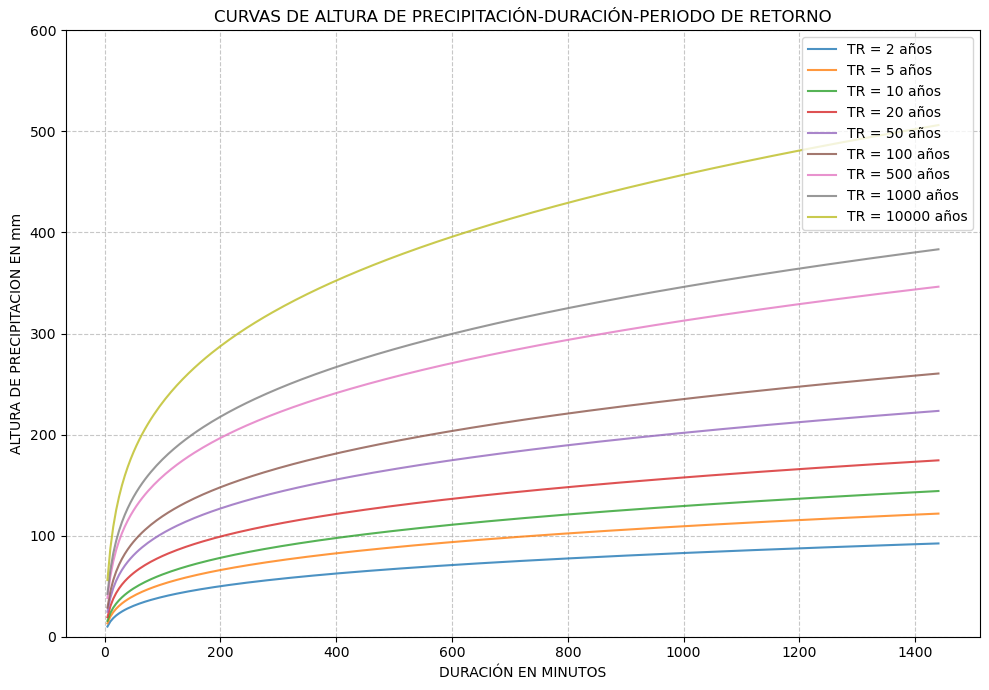

In [31]:
columnas_precipitacion = [2, 5, 10, 20, 50, 100, 500, 1000, 10000]

plt.figure(figsize=(10, 7))

for columna in columnas_precipitacion:
    plt.plot(df['TR (AÑOS)'], df[columna], label=f'TR = {columna} años', alpha=0.8)

plt.xlabel('DURACIÓN EN MINUTOS')
plt.ylabel('ALTURA DE PRECIPITACION EN mm')
plt.title('CURVAS DE ALTURA DE PRECIPITACIÓN-DURACIÓN-PERIODO DE RETORNO')
plt.ylim(0, 600)
#plt.legend(bbox_to_anchor=(0.5, -0.15), loc='lower center', ncol=len(columnas_precipitacion), frameon=False)
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

try:
    plt.savefig('imagen/CURVAS_ALTURA_PRECIPITACIÓN-DURACIÓN-TR_2-10000', dpi=600, bbox_inches='tight')
    print(f"CURVAS_ALTURA_PRECIPITACIÓN-DURACIÓN-TR_2-10000' en {os.getcwd()}")
except Exception as e:
    print(f"Error al guardar el gráfico: {e}")

# Mostrar el gráfico
plt.show()

CURVAS DE ALTURA DE PRECIPITACIÓN-DURACIÓN-PERIODO DE RETORNO' en C:\Users\USER\Desktop\Angel


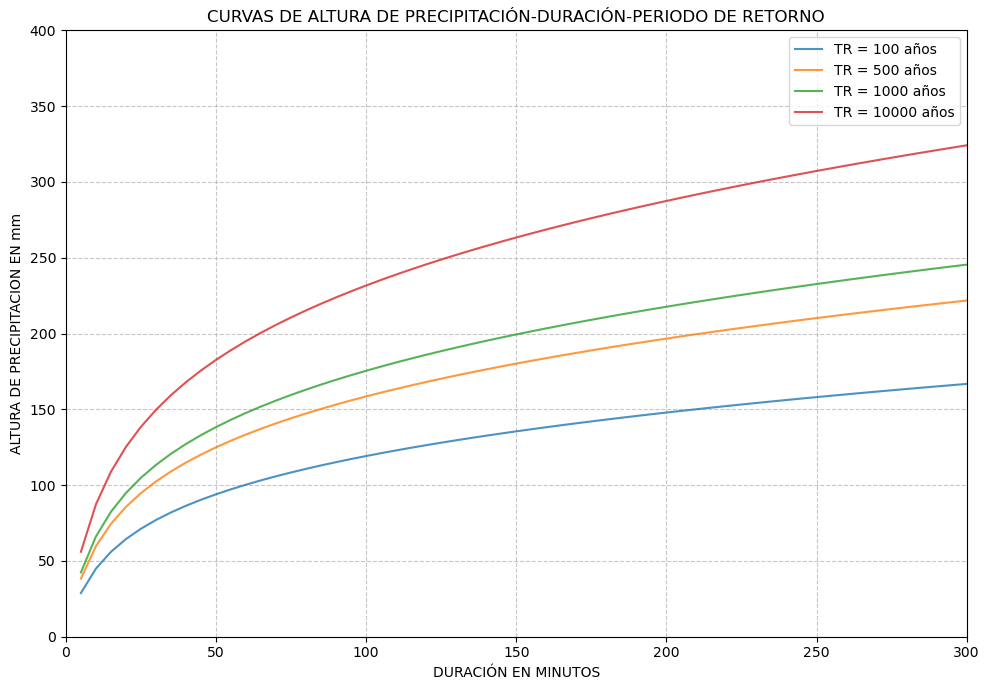

In [32]:

columnas_precipitacion = [100, 500, 1000, 10000]

df_filtrado = df[(df['TR (AÑOS)'] >= 0) & (df['TR (AÑOS)'] <= 300)]

plt.figure(figsize=(10, 7))

for columna in columnas_precipitacion:
    plt.plot(df_filtrado['TR (AÑOS)'], df_filtrado[columna], label=f'TR = {columna} años', alpha=0.8)


plt.xlabel('DURACIÓN EN MINUTOS')
plt.ylabel('ALTURA DE PRECIPITACION EN mm')
plt.title('CURVAS DE ALTURA DE PRECIPITACIÓN-DURACIÓN-PERIODO DE RETORNO')
plt.ylim(0, 400)
plt.xlim(0, 300)
#plt.legend(bbox_to_anchor=(0.5, -0.15), loc='lower center', ncol=len(columnas_precipitacion), frameon=False)
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

try:
    plt.savefig('imagen/CURVAS_ALTURA_PRECIPITACIÓN-DURACIÓN-TR_100-10000', dpi=600, bbox_inches='tight')
    print(f"CURVAS DE ALTURA DE PRECIPITACIÓN-DURACIÓN-PERIODO DE RETORNO' en {os.getcwd()}")
except Exception as e:
    print(f"Error al guardar el gráfico: {e}")

# Mostrar el gráfico
plt.show()

# CURVAS DE INTENSIDAD-DURACIÓN-PERÍODO DE RETORNO

In [33]:
df_2 = pd.DataFrame({
    'TR (AÑOS)': tr_valores,
    2: np.nan,
    5: np.nan,
    10: np.nan,
    20: np.nan,
    50: np.nan,
    100: np.nan,
    500: np.nan,
    1000: np.nan,
    10000: np.nan
})

# Mostrar el DataFrame
#print(df_2)

In [34]:
df_2[2] =  ((0.35 * math.log(TR[0]) + 0.76) * ((0.54 * (df['TR (AÑOS)'] ** 0.25)) - 0.5) * AP_60_2) * 60 / df_2['TR (AÑOS)'] 
df_2[5] =  ((0.35 * math.log(TR[1]) + 0.76) * ((0.54 * (df['TR (AÑOS)'] ** 0.25)) - 0.5) * AP_60_2) * 60 / df_2['TR (AÑOS)'] 
df_2[10] = ((0.35 * math.log(TR[2]) + 0.76) * ((0.54 * (df['TR (AÑOS)'] ** 0.25)) - 0.5) * AP_60_2) * 60 / df_2['TR (AÑOS)'] 
df_2[20] =   (p_r_a * AP_60_10 * math.log10((10 ** (2-p_r_f)) * TR[3] **(p_r_f - 1)) * df['TR (AÑOS)'])/(60 * ((df['TR (AÑOS)'] + p_r_b)** p_r_c)) * 60 / df_2['TR (AÑOS)'] 
df_2[50] =   (p_r_a * AP_60_10 * math.log10((10 ** (2-p_r_f)) * TR[4] **(p_r_f - 1)) * df['TR (AÑOS)'])/(60 * ((df['TR (AÑOS)'] + p_r_b)** p_r_c)) * 60 / df_2['TR (AÑOS)'] 
df_2[100] =  (p_r_a * AP_60_10 * math.log10((10 ** (2-p_r_f)) * TR[5] **(p_r_f - 1)) * df['TR (AÑOS)'])/(60 * ((df['TR (AÑOS)'] + p_r_b)** p_r_c)) * 60 / df_2['TR (AÑOS)'] 
df_2[500] =  (p_r_a * AP_60_10 * math.log10((10 ** (2-p_r_f)) * TR[6] **(p_r_f - 1)) * df['TR (AÑOS)'])/(60 * ((df['TR (AÑOS)'] + p_r_b)** p_r_c)) * 60 / df_2['TR (AÑOS)'] 
df_2[1000] = (p_r_a * AP_60_10 * math.log10((10 ** (2-p_r_f)) * TR[7] **(p_r_f - 1)) * df['TR (AÑOS)'])/(60 * ((df['TR (AÑOS)'] + p_r_b)** p_r_c)) * 60 / df_2['TR (AÑOS)'] 
df_2[10000] = (p_r_a * AP_60_10 * math.log10((10 ** (2-p_r_f)) * TR[8] **(p_r_f - 1)) * df['TR (AÑOS)'])/(60 * ((df['TR (AÑOS)'] + p_r_b)** p_r_c)) * 60 / df_2['TR (AÑOS)'] 

print(df_2)

df_2.to_csv('Tablas_Resultados/CurvasIntensidad-Duracion-TR.csv')

     TR (AÑOS)           2           5          10          20          50  \
0            5  120.495246  159.038013  188.194491  231.733134  296.670786   
1           10   90.183018  119.029824  140.851591  180.593434  231.200412   
2           15   73.503505   97.015043  114.800834  150.070341  192.123955   
3           20   62.891201   83.008185   98.226096  129.512450  165.805208   
4           25   55.447683   73.183711   86.600499  114.595440  146.708064   
..         ...         ...         ...         ...         ...         ...   
283       1420    3.884011    5.126389    6.066211    7.345850    9.404348   
284       1425    3.874390    5.113690    6.051184    7.327262    9.380552   
285       1430    3.864826    5.101066    6.036246    7.308787    9.356899   
286       1435    3.855318    5.088517    6.021396    7.290422    9.333388   
287       1440    3.845865    5.076041    6.006632    7.272166    9.310017   

            100         500        1000       10000  
0    345.

CURVAS DE INTENSIDAD-DURACIÓN-PERIODO DE RETORNO' en C:\Users\USER\Desktop\Angel


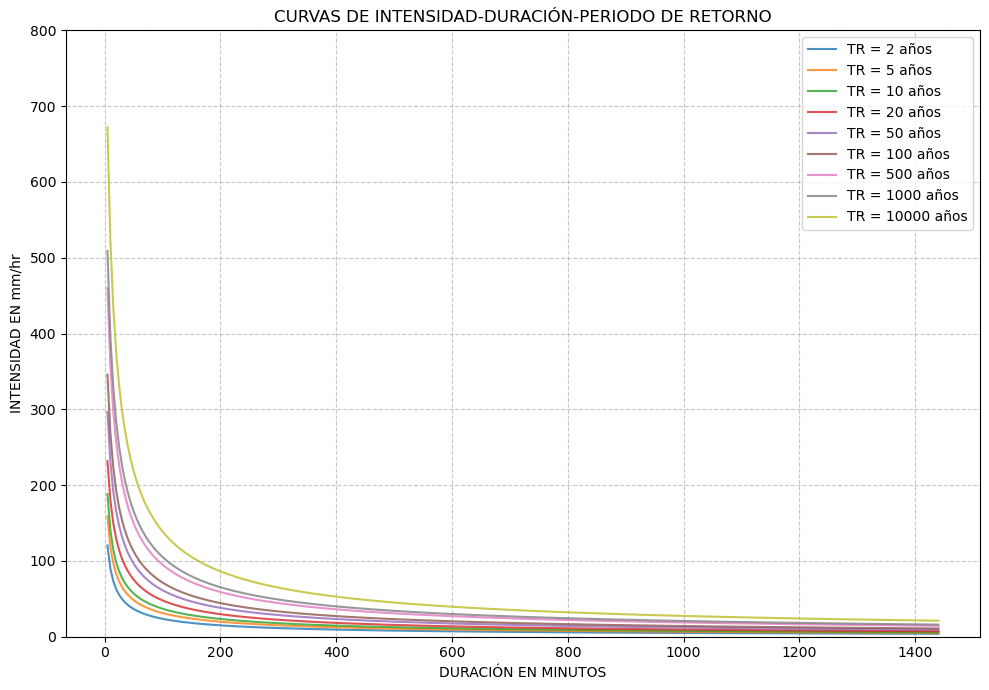

In [35]:
columnas_precipitacion = [2, 5, 10, 20, 50, 100, 500, 1000, 10000]

plt.figure(figsize=(10, 7))

for columna in columnas_precipitacion:
    plt.plot(df_2['TR (AÑOS)'], df_2[columna], label=f'TR = {columna} años', alpha=0.8)

plt.xlabel('DURACIÓN EN MINUTOS')
plt.ylabel('INTENSIDAD EN mm/hr')
plt.title('CURVAS DE INTENSIDAD-DURACIÓN-PERIODO DE RETORNO')
plt.ylim(0, 800)
#plt.legend(bbox_to_anchor=(0.5, -0.15), loc='lower center', ncol=len(columnas_precipitacion), frameon=False)
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

try:
    plt.savefig('imagen/CURVAS_INTENSIDAD-DURACIÓN-TR_2-10000', dpi=600, bbox_inches='tight')
    print(f"CURVAS DE INTENSIDAD-DURACIÓN-PERIODO DE RETORNO' en {os.getcwd()}")
except Exception as e:
    print(f"Error al guardar el gráfico: {e}")

# Mostrar el gráfico
plt.show()

CURVAS DE INTENSIDAD-DURACIÓN-PERIODO DE RETORNO' en C:\Users\USER\Desktop\Angel


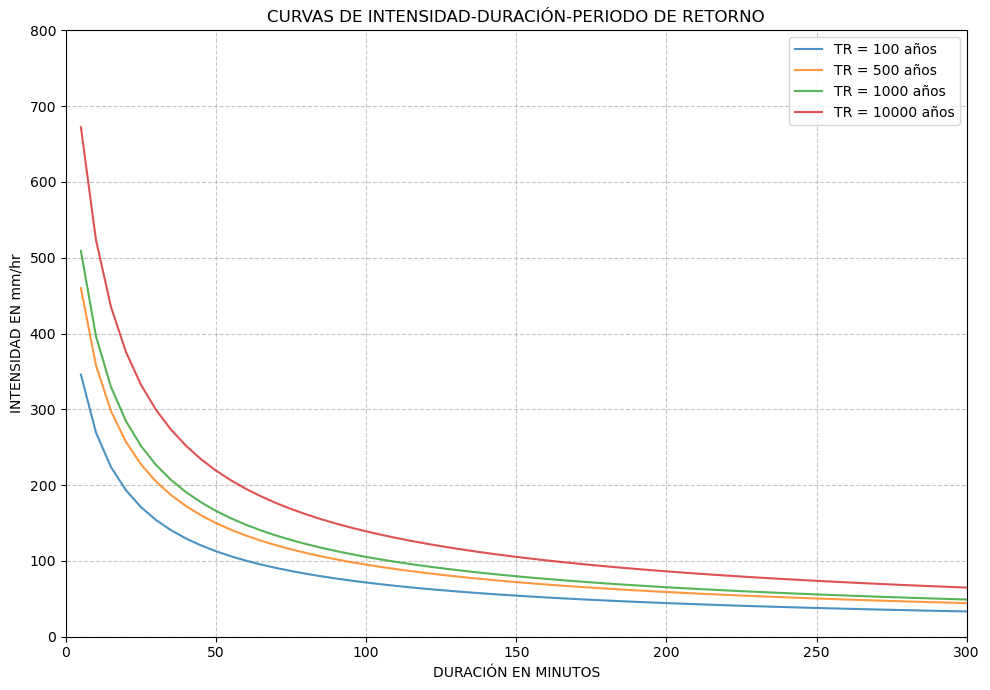

In [36]:

columnas_precipitacion = [100, 500, 1000, 10000]

df_filtrado = df_2[(df_2['TR (AÑOS)'] >= 0) & (df_2['TR (AÑOS)'] <= 300)]

plt.figure(figsize=(10, 7))

for columna in columnas_precipitacion:
    plt.plot(df_filtrado['TR (AÑOS)'], df_filtrado[columna], label=f'TR = {columna} años', alpha=0.8)


plt.xlabel('DURACIÓN EN MINUTOS')
plt.ylabel('INTENSIDAD EN mm/hr')
plt.title('CURVAS DE INTENSIDAD-DURACIÓN-PERIODO DE RETORNO')
plt.ylim(0, 800)
plt.xlim(0, 300)
#plt.legend(bbox_to_anchor=(0.5, -0.15), loc='lower center', ncol=len(columnas_precipitacion), frameon=False)
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

try:
    plt.savefig('imagen/CURVAS_INTENSIDAD-DURACIÓN-TR_100-10000', dpi=600, bbox_inches='tight')
    print(f"CURVAS DE INTENSIDAD-DURACIÓN-PERIODO DE RETORNO' en {os.getcwd()}")
except Exception as e:
    print(f"Error al guardar el gráfico: {e}")

# Mostrar el gráfico
plt.show()

## Coeficientes de escurrimiento ponderados

In [37]:
# Leer archivo con las areas en km
areas = pd.read_csv('INFO_Cuenca/areas_entrada.csv', header=0, index_col=0)

# Los nombres de las cuencas de cada fila deben ser únicos
if not areas.index.is_unique:
    duplicated = areas.index[areas.index.duplicated()]
    print("Advertencia: Hay nombres de cuenca repetidos en el CSV: ", list(duplicated.unique()))

print(areas)

                cs  concreto   asfalto  pasto-buena  pasto-media  pasto-pobre  \
nombre area                                                                     
Ext1         mas 7  0.365300       NaN     3.287880          NaN          NaN   
Ext2         mas 7  0.026082       NaN     2.582118          NaN          NaN   
Ext3         mas 7  0.035929       NaN     3.556971          NaN          NaN   
Ext4           2-7  0.200500       NaN     1.136200          NaN          NaN   
Ext5           2-7  0.675540       NaN     0.450360          NaN          NaN   
Ext6           2-7  0.996720       NaN     1.495080          NaN          NaN   
Ext7           0-2  2.386800       NaN     0.421200          NaN          NaN   
Ext8           0-2  1.640080       NaN     0.086320          NaN          NaN   
Ext9           0-2  2.280540       NaN     1.520360          NaN          NaN   
Ext10          0-2  2.356050       NaN     0.785350          NaN          NaN   
Ext11        mas 7  0.020691

In [38]:
# Leer archivo con las areas en km
areas = pd.read_csv('INFO_Cuenca/areas_entrada.csv', header=0, index_col=0)

# Los nombres de las cuencas de cada fila deben ser únicos
if not areas.index.is_unique:
    duplicated = areas.index[areas.index.duplicated()]
    print("Advertencia: Hay nombres de cuenca repetidos en el CSV: ", list(duplicated.unique()))

In [39]:
# Leer tablas de coeficientes de escurrimiento, cada dataframe corresponde a un valor C,S específico
coef_02 = pd.read_csv('INFO_Cuenca/coeficientes_0-2.csv', header=0, index_col=0)
missing_02 = [col for col in areas.columns[1:] if col not in coef_02.index]
if missing_02: print("Advertencia: Faltan códigos de área", missing_02, "en el CSV de coeficientes de escurrimiento 0-2%")

coef_27 = pd.read_csv('INFO_Cuenca/coeficientes_2-7.csv', header=0, index_col=0)
missing_27 = [col for col in areas.columns[1:] if col not in coef_27.index]
if missing_27: print("Advertencia: Faltan códigos de área", missing_02, "en el CSV de coeficientes de escurrimiento 2-7%")

# Obtener los tiempos de retorno que se manejan en las tablas (deben ser los mismos)
trs = coef_02.columns[1:]
if not coef_02.columns[1:].equals(coef_27.columns[1:]):
    print("Advertencia: Las columnas o tiempos de retorno manejados en las tablas no coinciden")

# Indexar cada dataframe según el valor C,S
# Por el momento se utiliza la tabla de 2-7% para C,S mayor a 7%
coeficientes = {
    "0-2": coef_02,
    "2-7": coef_27,
    "mas 7": coef_27}

In [40]:
# Crear nuevo dataframe vacío para llenar los coeficientes ponderados luego
# Las columnas son el área total y los coeficientes para cada tiempo de retorno
columnas = ['area'] + trs.to_list()
ponderados = pd.DataFrame(index=areas.index, columns=columnas)

# Generar coeficientes ponderados de las áreas

# Iterar por cuenca
for cuenca, row in areas.iterrows():
    cs = row['cs']
    # Iterar por tiempo de retorno
    for tr in trs:
        coef_total = 0
        area_total = 0
        # Iterar por código de área (concreto, asfalto, etc)
        for tipo_area in areas.columns[1:]:
            # Continuar si el área tiene un valor asignado, y no es 0
            if pd.notna(row[tipo_area]) and pd.notnull(row[tipo_area]) and row[tipo_area] > 0:
                    # Multiplicar coeficiente correspontiente por area, y sumarlo al total
                    area_coef = coeficientes[cs].loc[tipo_area, tr] * row[tipo_area]
                    coef_total += area_coef
                    area_total += row[tipo_area]

        # Asignar a la tabla final el valor ponderado
        ponderados.loc[cuenca, tr] = coef_total/area_total
        ponderados.loc[cuenca, 'area'] = area_total

print(ponderados)                 


                 area         2         5        10        20        50  \
nombre area                                                               
Ext1          3.65318  0.335998  0.367998  0.397998  0.418998  0.469998   
Ext2           2.6082    0.2946    0.3248    0.3548    0.3749     0.425   
Ext3           3.5929    0.2946    0.3248    0.3548    0.3749     0.425   
Ext4           1.3367  0.358998  0.391998  0.421998  0.443498  0.494998   
Ext5           1.1259     0.566     0.608     0.638     0.664      0.72   
Ext6           2.4918     0.474     0.512     0.542     0.566      0.62   
Ext7            2.808     0.669    0.7145     0.743    0.7745      0.83   
Ext8           1.7264     0.723    0.7715     0.801    0.8315      0.89   
Ext9           3.8009     0.534     0.572     0.598     0.632      0.68   
Ext10          3.1414     0.615    0.6575     0.685    0.7175      0.77   
Ext11          0.0209    0.7454    0.7952    0.8252    0.8551     0.915   
Ext12          0.0603    

## Tiempos de concentración
Leer Excel donde cada hoja tiene las cotas y distancias de cada cuenca, los nombres de las hojas deben coincidir exactamente con los nombres de cuencas utilizados en otras tablas

In [41]:
# Función para redondear TC al múltiplo de 5 más cercano hacia arriba, a menos que no pase de 1.0 del múltiplo anterior
# Si el valor es menor que 10, regresa 10
def redondear_tc(tc):
    if tc <= 10:
        return 10
    else:
        lower = (tc // 5) * 5
        upper = lower + 5
        if tc - lower < 1:
            return lower
        else:
            return upper

In [42]:
# Leer CSV de costas y distancias
dist_cotas_csv = pd.read_csv('INFO_Cuenca\distancias_cotas.csv')

# Agrupar las filas que corresponden a una misma cuenca en sub-dataframes
# Se generará un diccionario con un dataframe para cada cuenca
dist_cotas = {key: sub_df for key, sub_df in dist_cotas_csv.groupby('cuenca')}

# Las claves deben coincidir con los nombres de cuencas manejados en el CSV de áreas de entrada
if not set(areas.index) == set(dist_cotas.keys()):
    print("Advertencia: Los nombres de las cuencas no coinciden en los archivos de áreas y de distancias/cotas")
    faltan_dist = set(areas.index) - set(dist_cotas.keys())
    faltan_areas = set(dist_cotas.keys()) - set(areas.index)   
    if faltan_areas:
        print("Valores diferentes en CSV de áreas:", faltan_dist)
    if faltan_dist:
        print("Valores diferentes en CSV de distancias/cotas:", faltan_areas)

Advertencia: Los nombres de las cuencas no coinciden en los archivos de áreas y de distancias/cotas
Valores diferentes en CSV de distancias/cotas: set()


<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
C:\Users\USER\AppData\Local\Temp\ipykernel_3576\3216373754.py:2: SyntaxWarning: invalid escape sequence '\d'
  dist_cotas_csv = pd.read_csv('INFO_Cuenca\distancias_cotas.csv')


In [43]:
# Crear dataframe donde se guardarán los tiempos de concentración
tcs = pd.DataFrame(index=list(dist_cotas.keys()), columns=['pendiente', 'tc real', 'tc aprox'])

# Iterar por cuenca
for cuenca, df in dist_cotas.items():
    row_count = df.shape[0]  # Número de filas
    # Si hay más de una fila, aplicar cálculo de pendiente de Schwarz y Taylor
    if (row_count > 1):
        lcp = 0
        denominador_lcp = 0
        # Iterar por fila
        for zona, row in df.iterrows():
            dif_cotas = abs(row['cota mayor'] - row['cota menor'])
            dif_dist = abs(row['distancia2'] - row['distancia1'])
            s_parcial = dif_cotas / dif_dist
            lcp += dif_dist
            denominador_lcp += dif_dist / math.sqrt(s_parcial)
        
        pendiente_st = (lcp / denominador_lcp) ** 2
        tcs.loc[cuenca, 'pendiente'] = pendiente_st
        tcs.loc[cuenca, 'tc real'] = (0.000325*((lcp**0.77)/(pendiente_st**0.385)))*60
        tcs.loc[cuenca, 'tc aprox'] = redondear_tc(tcs.loc[cuenca, 'tc real'])

    elif row_count == 1:
        row = df.iloc[0]
        dif_cotas = abs(row['cota mayor'] - row['cota menor'])
        dif_dist = abs(row['distancia2'] - row['distancia1'])
        s = dif_cotas / dif_dist
        tcs.loc[cuenca, 'pendiente'] = s
        tcs.loc[cuenca, 'tc real'] = (0.000325*((dif_dist**0.77)/(s**0.385)))*60
        tcs.loc[cuenca, 'tc aprox'] = redondear_tc(tcs.loc[cuenca, 'tc real'])
    else:
        print(f"Advertencia: Hoja {cuenca} sin filas")

print(tcs)

      pendiente    tc real tc aprox
Ext1   0.097584  31.458614     35.0
Ext10  0.033633  37.193059     40.0
Ext11  0.011882    5.17348       10
Ext12  0.010588   7.101911       10
Ext13  0.032006      3.724       10
Ext14  0.069307   8.762885       10
Ext2   0.239159  18.547681     20.0
Ext3   0.202895  20.560201     20.0
Ext4   0.064542  21.256174     25.0
Ext5   0.041238   23.98355     25.0
Ext6   0.064716  27.486963     30.0
Ext7   0.013992  43.160318     45.0
Ext8   0.008246  51.785008     55.0
Ext9        NaN        NaN      NaN


## Método racional

In [44]:
df_3 = df_2.copy()

df_3.columns.values[0] = 'minutos'
print(df_3)


     minutos           2           5          10          20          50  \
0          5  120.495246  159.038013  188.194491  231.733134  296.670786   
1         10   90.183018  119.029824  140.851591  180.593434  231.200412   
2         15   73.503505   97.015043  114.800834  150.070341  192.123955   
3         20   62.891201   83.008185   98.226096  129.512450  165.805208   
4         25   55.447683   73.183711   86.600499  114.595440  146.708064   
..       ...         ...         ...         ...         ...         ...   
283     1420    3.884011    5.126389    6.066211    7.345850    9.404348   
284     1425    3.874390    5.113690    6.051184    7.327262    9.380552   
285     1430    3.864826    5.101066    6.036246    7.308787    9.356899   
286     1435    3.855318    5.088517    6.021396    7.290422    9.333388   
287     1440    3.845865    5.076041    6.006632    7.272166    9.310017   

            100         500        1000       10000  
0    345.794224  459.855315  508.

In [45]:
if 'T' in df_3.columns:
    df_3.set_index('minutos', inplace=True)
    print("Índice establecido como 'minutos'")
else:
    print("Columna 'minutos' no encontrada. Columnas disponibles:")
    print(df_3.columns.tolist())

Columna 'minutos' no encontrada. Columnas disponibles:
['minutos', 2, 5, 10, 20, 50, 100, 500, 1000, 10000]


In [46]:
df_3 = df_3.reset_index()
print(df_3.columns.tolist())

['index', 'minutos', 2, 5, 10, 20, 50, 100, 500, 1000, 10000]


In [47]:
df_3.set_index(df_3.columns[0], inplace=True)
print(df_3.columns.tolist())

['minutos', 2, 5, 10, 20, 50, 100, 500, 1000, 10000]


In [48]:
df_3.set_index(df_3.columns[0], inplace=True)
print(df_3.columns.tolist())
df_3.to_csv('INFO_Cuenca/df_3_completo.csv')

[2, 5, 10, 20, 50, 100, 500, 1000, 10000]


In [49]:
# Leer tabla de intensidades
intensidades = pd.read_csv('INFO_Cuenca/df_3_completo.csv', header=0, index_col=0) # df_3 

### Gastos de metodo racional 

0.278 * C *I *A

In [50]:
# Crear nuevo dataframe para los resultados
resultados = pd.DataFrame(index=ponderados.index, columns=trs)

# Iterar por cuenca
for cuenca, row in ponderados.iterrows():
    # Iterar por tiempo de retorno
    for tr in trs:
        tc = tcs.loc[cuenca, 'tc aprox']
        print(f"{row[tr]}")# {intensidades.loc[tc, tr]}, {row['area'],}
        resultados.loc[cuenca, tr] = 0.278 * row[tr] * intensidades.loc[tc, tr] * row['area']

print(resultados)
resultados.to_csv('Tablas_Resultados/GastosMetodoRacional.csv')

0.33599773348151474
0.3679976349372328
0.3979976349372328
0.41899758566509177
0.4699975363929508
0.5109974871208098
0.6039978320257967
0.6849982754750656
0.2946
0.3248
0.35479999999999995
0.37489999999999996
0.425
0.46509999999999996
0.5644
0.6535
0.2946
0.32480000000000003
0.3548
0.37489999999999996
0.425
0.46510000000000007
0.5644
0.6535000000000001
0.3589982793446547
0.3919982045335528
0.4219982045335528
0.44349816712800183
0.49499812972245083
0.5364980923168999
0.6259983541557569
0.7024986908057157
0.566
0.608
0.638
0.6639999999999999
0.72
0.7659999999999999
0.824
0.86
0.474
0.512
0.5419999999999999
0.5660000000000001
0.6200000000000001
0.664
0.736
0.79
0.669
0.7145
0.743
0.7745000000000001
0.83
0.8785
0.9235000000000001
0.934
0.723
0.7715000000000001
0.8009999999999999
0.8314999999999999
0.8900000000000001
0.9395000000000001
0.9744999999999999
0.9780000000000001
0.534


KeyError: nan

## Coeficientes N ponderados

In [ ]:
# Leer tabla de coeficientes N 
coef_n = pd.read_csv('INFO_Cuenca/coeficientes_n.csv', header=0, index_col=0)

# Revisar que todos los códigos de áreas utilizados estén presentes en la tabla de coeficientes N
missing = [col for col in areas.columns[1:] if areas[col].notna().any() and col not in coef_n.index]
if missing: print("Advertencia: Faltan códigos de área", missing, "en el CSV de coeficientes N")